In [1]:
#basic tools 
import os
import numpy as np
import pandas as pd
import warnings


#graph, plots
import matplotlib.pyplot as plt
import seaborn as sns

#building models
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
import time
import sys

#metrics 
from sklearn.metrics import roc_auc_score, roc_curve
warnings.simplefilter(action='ignore', category=FutureWarning)



import datetime
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None) 
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler


import warnings
warnings.filterwarnings('ignore')

/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso

In [3]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [4]:
dataall = pd.read_csv('QuadData2 - QuadData.csv')
data = pd.read_csv('QuadData2 - QuadData.csv')

# dataall = pd.read_csv('QuadData.csv')
# dataall = dataall.drop(['DeviceID'], axis =1)
# a = dataall[dataall.columns[1:-1]].apply(lambda x: x.corr(dataall['Lng']))
# a.sort_values(ascending=True) 

In [5]:
# a = dataall[dataall.columns[1:-1]].apply(lambda x: x.corr(dataall['Lat']))
# a.sort_values(ascending=True)

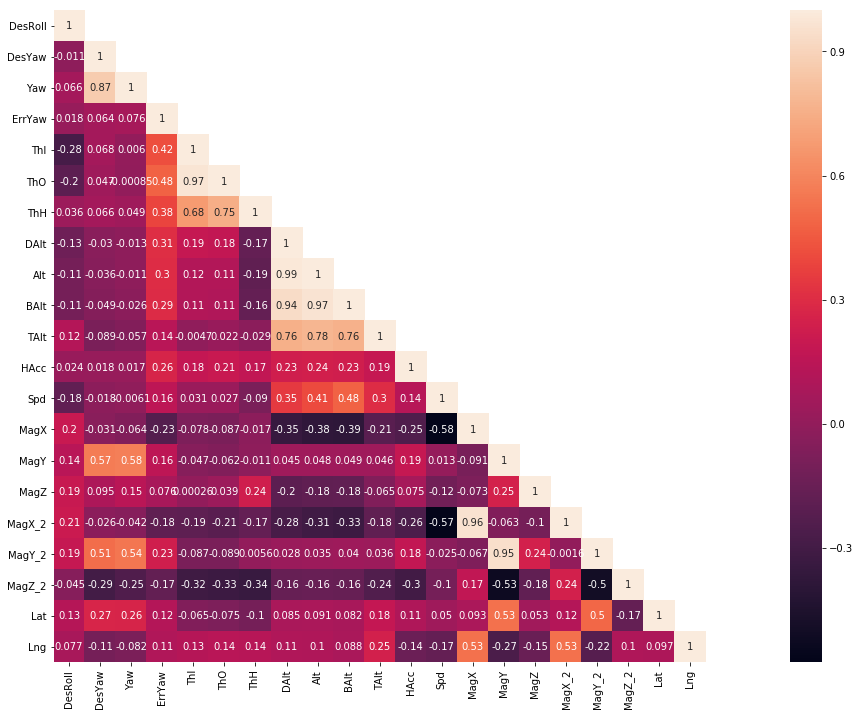

In [6]:
datacorr = pd.read_csv('QuadData.csv')
datacorr = datacorr.drop(['id',
                         'TimeUS_CTUN','TimeUS_GPA','TimeUS_GPS','TimeUS_IMU','TimeUS_IMU2','TimeUS_ATT',
                         'TimeUS_MAG','TimeUS_MAG2','TimeUS_RCOU',
                        'LineNo_CTUN','LineNo_GPA','LineNo_GPS','LineNo_IMU','LineNo_IMU2','LineNo_ATT',
                        'LineNo_MAG','LineNo_MAG2','LineNo_RCOU', 'OfsY_2','OfsX_2','OfsZ_2', 'Delta', 'OfsY','OfsX','OfsZ', 'DSAlt',      'SAlt','VV','GWk','MOfsX','MOfsY','MOfsZ','MOfsX_2','MOfsY_2','MOfsZ_2',
                         'SMS','GMS','ABst','Delta','C3','VAcc','CRt','ExpID','PatternID',
                          'GyrX_2','DCRt','GyrY_2','GyrY','GyrX','C2' , 'C4','C1','VDop','DesPitch','HDop','Status','AccZ_2','AccZ','SAcc','ErrRP', 'AccX_2',
'GyrZ','GyrZ_2','Pitch','AccX','NSats', 'GCrs','AccY','AccY_2','Roll','Alt.1'
                         ],axis=1)


cor_mat= datacorr[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [7]:
a = datacorr[datacorr.columns[1:-1]].apply(lambda x: x.corr(datacorr['Lng']))
a.sort_values(ascending=True)

MagY      -0.268329
MagY_2    -0.220413
Spd       -0.167901
MagZ      -0.150120
HAcc      -0.141971
DesYaw    -0.107161
Yaw       -0.082373
DesRoll    0.076967
BAlt       0.087521
Lat        0.097022
MagZ_2     0.101509
Alt        0.103108
ErrYaw     0.111229
DAlt       0.111691
ThI        0.126140
ThH        0.136479
ThO        0.143264
TAlt       0.245233
MagX_2     0.525782
MagX       0.527029
dtype: float64

In [8]:
#Mengecek apakah ada null
dataall.isnull().sum()

id                  0
ExpID               0
PatternID           0
DeviceID            0
LineNo_ATT          0
Time_ID             0
TimeUS_ATT          0
Timedif1            0
TimeUS_ATT_1        0
DesRoll             0
Roll                0
DesPitch            0
Pitch               0
DesYaw              0
Yaw                 0
ErrRP               0
ErrYaw              0
LineNo_CTUN         0
TimeUS_CTUN         0
Timedif2            0
TimeUS_CTUN_1       0
ThI                 0
ABst                0
ThO                 0
ThH                 0
DAlt                0
Alt                 0
BAlt                0
DSAlt            8791
SAlt                0
TAlt                0
DCRt                0
CRt                 0
LineNo_GPA          0
TimeUS_GPA          0
VDop                0
HAcc                0
VAcc                0
SAcc                0
VV                  0
SMS                 0
Delta               0
LineNo_GPS          0
TimeUS_GPS          0
TimeUS_GPS_1        0
Status    

In [9]:
#Mengubah fitur yang seharusnya categorical tapi masih numeric dijadikan string duku
dataall['Status'] = dataall['Status'].apply(str)
dataall['ExpID'] = dataall['ExpID'].apply(str)
dataall['PatternID'] = dataall['PatternID'].apply(str)

#Mengisi NA dengan -1 berguna untuk test set
dataall = dataall.fillna(-1)
dataall.head()

,id,ExpID,PatternID,DeviceID,LineNo_ATT,Time_ID,TimeUS_ATT,Timedif1,TimeUS_ATT_1,DesRoll,Roll,DesPitch,Pitch,DesYaw,Yaw,ErrRP,ErrYaw,LineNo_CTUN,TimeUS_CTUN,Timedif2,TimeUS_CTUN_1,ThI,ABst,ThO,ThH,DAlt,Alt,BAlt,DSAlt,SAlt,TAlt,DCRt,CRt,LineNo_GPA,TimeUS_GPA,VDop,HAcc,VAcc,SAcc,VV,SMS,Delta,LineNo_GPS,TimeUS_GPS,TimeUS_GPS_1,Status,GMS,GWk,NSats,HDop,Alt.1,Spd,GCrs,LineNo_IMU,TimeUS_IMU,TimeUS_IMU_1,GyrX,GyrY,GyrZ,AccX,AccY,AccZ,LineNo_IMU2,TimeUS_IMU2,TimeUS_IMU2_1,GyrX_2,GyrY_2,GyrZ_2,AccX_2,AccY_2,AccZ_2,LineNo_MAG,TimeUS_MAG,TimeUS_MAG_1,MagX,MagY,MagZ,OfsX,OfsY,OfsZ,MOfsX,MOfsY,MOfsZ,LineNo_MAG2,TimeUS_MAG2,TimeUS_MAG2_1,MagX_2,MagY_2,MagZ_2,OfsX_2,OfsY_2,OfsZ_2,MOfsX_2,MOfsY_2,MOfsZ_2,LineNo_RCOU,TimeUS_RCOU,TimeUS_RCOU_1,C1,C2,C3,C4,Lat1,Lng1,Lat2,Lng2,minLat,minLong,LatPat,LngPat,Lat,Lng
0,0,6,2,F450,14206,1,867051417,0,6/23/1997 14:36:57,-2.52,-0.74,-2.30,-1.55,359.96,2.12,0.10,0.03,14205,867049441,0,6/23/1997 14:04:01,0.555876,0.000247,0.546026,0.497376,-0.296357,-0.234196,0.17,-1.0,0,1.502355,-56,-55,14219,867309420,1.12,0.58,0.96,0.21,1,867309,200,14218,867309420,6/26/1997 14:17:00,4,554817200,2065,14,0.77,215.19,0.391,187.2020,14210,867111541,6/24/1997 7:19:01,0.078031,-0.032413,-0.226329,0.226690,-0.065972,-10.823730,14211,867111541,6/24/1997 7:19:01,0.073894,-0.020910,-0.218172,-0.119277,-0.180437,-10.886220,14203,867049114,6/23/1997 13:58:34,382,-12,-200,-158,-119,359,0,0,0,14204,867049114,6/23/1997 13:58:34,247,-138,-275,65,212,348,0,0,0,14207,867051676,6/23/1997 14:41:16,1536,1578,1719,1726,-6.557158,106.733964,-6.557158,106.733964,5.000000e-07,1.000010e-07,-6.557201,106.733936,-6.557158,106.733964
1,1,6,2,F450,14216,2,867251550,200133,6/25/1997 22:12:30,-2.64,0.28,-2.95,-1.02,359.96,359.69,0.12,0.02,14215,867249301,199860,6/25/1997 21:35:01,0.540934,0.000086,0.546892,0.497376,-0.396357,-0.332534,0.04,-1.0,0,1.403758,-56,-56,14229,867509424,1.12,0.58,0.95,0.25,1,867509,200,14228,867509424,6/28/1997 21:50:24,4,554817400,2065,14,0.77,215.10,0.242,187.2020,14220,867311487,6/26/1997 14:51:27,0.048311,-0.123246,-0.176451,1.294079,-0.242524,-9.683836,14221,867311487,6/26/1997 14:51:27,0.043921,-0.143682,-0.178176,0.497582,-0.190082,-9.850414,14213,867249035,6/25/1997 21:30:35,385,4,-193,-158,-119,359,0,0,0,14214,867249035,6/25/1997 21:30:35,284,-107,-277,65,212,348,0,0,0,14217,867251950,6/25/1997 22:19:10,1581,1553,1697,1733,-6.557158,106.733964,-6.557158,106.733964,5.000000e-07,1.000010e-07,-6.557201,106.733936,-6.557158,106.733964
2,2,6,2,F450,14226,3,867451412,199862,6/28/1997 5:43:32,-2.80,-0.42,-3.46,-1.85,359.96,357.66,0.11,0.02,14225,867449087,199786,6/28/1997 5:04:47,0.540462,0.000329,0.541243,0.497376,-0.496357,-0.421786,0.11,-1.0,0,1.314110,-57,-51,14239,867709368,1.12,0.58,0.96,0.27,1,867709,200,14238,867709368,7/1/1997 5:22:48,4,554817600,2065,14,0.77,215.07,0.016,187.2020,14230,867511687,6/28/1997 22:28:07,-0.116384,-0.149578,-0.116427,0.966332,-0.033429,-10.370030,14231,867511687,6/28/1997 22:28:07,-0.146389,-0.144665,-0.108821,1.018969,0.316950,-9.909281,14223,867448904,6/28/1997 5:01:44,387,12,-196,-158,-119,359,0,0,0,14224,867448904,6/28/1997 5:01:44,257,-103,-278,65,212,348,0,0,0,14227,867451674,6/28/1997 5:47:54,1601,1540,1690,1726,-6.557158,106.733964,-6.557158,106.733964,5.000000e-07,1.000010e-07,-6.557202,106.733936,-6.557159,106.733964
3,3,6,2,F450,14236,4,867651882,200470,6/30/1997 13:24:42,-2.63,-1.31,-3.70,-3.97,359.96,356.25,0.11,0.02,14235,867649120,200033,6/30/1997 12:38:40,0.509038,0.001363,0.525917,0.497376,-0.596357,-0.506052,-0.16,-1.0,0,1.229523,-59,-54,14249,867909381,1.12,0.58,0.96,0.23,1,867909,200,14248,867909381,7/3/1997 12:56:21,4,554817800,2065,14,0.77,215.02,0.236,215.8407,14240,867711867,7/1/1997 6:04:27,0.153803,-0.058657,-0.064778,0.123401,-0.263345,-9.462250,14241,867711867,7/1/1997 6:04:27,0.127449,-0.063853,-0.057500,-0.090306,0.768961,-9.291891,14233,867648947,6/30/1997 12:35:47,373,27,-207,-158,-119,359,0,0,0,14234,867648947,6/30/1997 12:35:47,244,-94,-290,65,212,348

In [10]:
#Drop fitur tidak penting serta
dataall = dataall.drop(['DSAlt','id','TimeUS_CTUN_1','TimeUS_GPS_1','TimeUS_IMU_1','TimeUS_IMU2_1',
                        'TimeUS_ATT_1','TimeUS_MAG_1','TimeUS_MAG2_1','TimeUS_RCOU_1',
                        'SAlt','VV','GWk','MOfsX','MOfsY','MOfsZ','MOfsX_2','MOfsY_2','MOfsZ_2',
                         'TimeUS_CTUN','TimeUS_GPA','TimeUS_GPS','TimeUS_IMU','TimeUS_IMU2','TimeUS_ATT',
                         'TimeUS_MAG','TimeUS_MAG2','TimeUS_RCOU',
                        'LineNo_CTUN','LineNo_GPA','LineNo_GPS','LineNo_IMU','LineNo_IMU2','LineNo_ATT',
                        'LineNo_MAG','LineNo_MAG2','LineNo_RCOU',
                        'SMS','GMS',
                        'Lat2','Lng2','minLat','minLong',
                        'OfsY_2','OfsX_2','OfsZ_2', 'Delta', 'OfsY','OfsX','OfsZ', 'Timedif1','Timedif2'

                      #  'ABst','Delta','C3','VAcc','CRt'
                       ],axis=1)

#One Hot Encoder untuk categorical
dataall = pd.get_dummies(dataall)

#Menghapus salah satu hasil encode untuk fitur yang hanya memiliki 2 kategori
dataall = dataall.drop(['DeviceID_F450','Status_4','PatternID_2'],axis=1)
#dataall = dataall.sort_values(by=['Time_ID'])
dataall.head(20)

,Time_ID,DesRoll,Roll,DesPitch,Pitch,DesYaw,Yaw,ErrRP,ErrYaw,ThI,ABst,ThO,ThH,DAlt,Alt,BAlt,TAlt,DCRt,CRt,VDop,HAcc,VAcc,SAcc,NSats,HDop,Alt.1,Spd,GCrs,GyrX,GyrY,GyrZ,AccX,AccY,AccZ,GyrX_2,GyrY_2,GyrZ_2,AccX_2,AccY_2,AccZ_2,MagX,MagY,MagZ,MagX_2,MagY_2,MagZ_2,C1,C2,C3,C4,Lat1,Lng1,LatPat,LngPat,Lat,Lng,ExpID_1,ExpID_10,ExpID_11,ExpID_12,ExpID_2,ExpID_3,ExpID_4,ExpID_5,ExpID_6,ExpID_7,ExpID_8,ExpID_9,PatternID_1,DeviceID_F330,Status_3
0,1,-2.52,-0.74,-2.30,-1.55,359.96,2.12,0.10,0.03,0.555876,0.000247,0.546026,0.497376,-0.296357,-0.234196,0.17,1.502355,-56,-55,1.12,0.58,0.96,0.21,14,0.77,215.19,0.391,187.2020,0.078031,-0.032413,-0.226329,0.226690,-0.065972,-10.823730,0.073894,-0.020910,-0.218172,-0.119277,-0.180437,-10.886220,382,-12,-200,247,-138,-275,1536,1578,1719,1726,-6.557158,106.733964,-6.557201,106.733936,-6.557158,106.733964,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2,-2.64,0.28,-2.95,-1.02,359.96,359.69,0.12,0.02,0.540934,0.000086,0.546892,0.497376,-0.396357,-0.332534,0.04,1.403758,-56,-56,1.12,0.58,0.95,0.25,14,0.77,215.10,0.242,187.2020,0.048311,-0.123246,-0.176451,1.294079,-0.242524,-9.683836,0.043921,-0.143682,-0.178176,0.497582,-0.190082,-9.850414,385,4,-193,284,-107,-277,1581,1553,1697,1733,-6.557158,106.733964,-6.557201,106.733936,-6.557158,106.733964,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,3,-2.80,-0.42,-3.46,-1.85,359.96,357.66,0.11,0.02,0.540462,0.000329,0.541243,0.497376,-0.496357,-0.421786,0.11,1.314110,-57,-51,1.12,0.58,0.96,0.27,14,0.77,215.07,0.016,187.2020,-0.116384,-0.149578,-0.116427,0.966332,-0.033429,-10.370030,-0.146389,-0.144665,-0.108821,1.018969,0.316950,-9.909281,387,12,-196,257,-103,-278,1601,1540,1690,1726,-6.557158,106.733964,-6.557202,106.733936,-6.557159,106.733964,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,4,-2.63,-1.31,-3.70,-3.97,359.96,356.25,0.11,0.02,0.509038,0.001363,0.525917,0.497376,-0.596357,-0.506052,-0.16,1.229523,-59,-54,1.12,0.58,0.96,0.23,14,0.77,215.02,0.236,215.8407,0.153803,-0.058657,-0.064778,0.123401,-0.263345,-9.462250,0.127449,-0.063853,-0.057500,-0.090306,0.768961,-9.291891,373,27,-207,244,-94,-290,1604,1529,1712,1683,-6.557158,106.733964,-6.557202,106.733936,-6.557159,106.733964,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,5,-2.38,-0.74,-2.95,-4.04,359.96,355.72,0.10,0.03,0.471022,0.001111,0.508583,0.497376,-0.696357,-0.581820,-0.17,1.153755,-61,-59,1.12,0.58,0.96,0.25,14,0.77,214.98,0.098,215.8407,0.149147,0.215911,-0.013916,-0.066849,-0.357280,-10.605320,0.145377,0.196375,-0.012828,0.500610,-0.134041,-9.741194,370,41,-215,265,-78,-296,1594,1520,1682,1693,-6.557158,106.733964,-6.557202,106.733936,-6.557159,106.733964,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,6,-2.32,0.31,-1.61,-1.65,359.96,355.55,0.11,0.03,0.517891,0.000229,0.501004,0.497376,-0.796357,-0.655690,-0.17,1.079534,-64,-51,1.12,0.58,0.96,0.27,14,0.77,214.86,0.150,215.8407,0.060977,0.233284,-0.018650,0.495591,0.150813,-9.391306,0.051357,0.230988,-0.014196,0.455218,0.422455,-9.255808,376,36,-208,288,-56,-277,1524,1582,1673,1692,-6.557158,106.733964,-6.557201,106.733937,-6.557158,106.733964,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6,7,-2.49,0.34,-0.90,0.36,359.96,355.23,0.10,0.04,0.543821,0.000021,0.503228,0.497376,-0.896357,-0.739577,-0.26,0.995723,-65,-50,1.12,0.58,0.96,0.25,14,0.77,214.76,0.219,215.8407,-0.001372,-0.094332,-0.094507,0.170589,0.015462,-8.991995,-0.009329,-0.083192,-0.087135,0.098585,-0.189777,-8.705786,390,36,-195,255,-86,-269,1609,1495,1686,1674,-6.557158,106.733964,-6.557201,106.733937,-6.557158,106.733964,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
7,8,-2.80,-0.68,-0.78,-0.65,359.96,354.10,0.08,0.03,0.525331,0.000075,0.507436,0.497376,-0.996357,-0.841560,-0.49,0.893908,-65,-57,1.12,0.58,0.96,0.25,14,0.77,214.70,0.257,215.8407,-0.193125,-0.131751,-0.182276,-0.155336,-0.379440,-9.488565,-0.192371,-0.137255,-0.172628,-0.283743,-0.316033,-9.301373,389,41,-187,267,-84,-270,1602,1529,1692,1663,-6.557158,106.733964,-6.557200,106.733937,-6.557157,106.733964,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
8,9,-2.69,-2.30,-0.58,-1.15,359.96,351.84,0.07,0.03,0.516257,0.000503,0.510640,0.4

In [11]:
#memisihkan data train dan data test asli
train = dataall[dataall['Lat'] != -1]
train.head()

,Time_ID,DesRoll,Roll,DesPitch,Pitch,DesYaw,Yaw,ErrRP,ErrYaw,ThI,ABst,ThO,ThH,DAlt,Alt,BAlt,TAlt,DCRt,CRt,VDop,HAcc,VAcc,SAcc,NSats,HDop,Alt.1,Spd,GCrs,GyrX,GyrY,GyrZ,AccX,AccY,AccZ,GyrX_2,GyrY_2,GyrZ_2,AccX_2,AccY_2,AccZ_2,MagX,MagY,MagZ,MagX_2,MagY_2,MagZ_2,C1,C2,C3,C4,Lat1,Lng1,LatPat,LngPat,Lat,Lng,ExpID_1,ExpID_10,ExpID_11,ExpID_12,ExpID_2,ExpID_3,ExpID_4,ExpID_5,ExpID_6,ExpID_7,ExpID_8,ExpID_9,PatternID_1,DeviceID_F330,Status_3
0,1,-2.52,-0.74,-2.30,-1.55,359.96,2.12,0.10,0.03,0.555876,0.000247,0.546026,0.497376,-0.296357,-0.234196,0.17,1.502355,-56,-55,1.12,0.58,0.96,0.21,14,0.77,215.19,0.391,187.2020,0.078031,-0.032413,-0.226329,0.226690,-0.065972,-10.823730,0.073894,-0.020910,-0.218172,-0.119277,-0.180437,-10.886220,382,-12,-200,247,-138,-275,1536,1578,1719,1726,-6.557158,106.733964,-6.557201,106.733936,-6.557158,106.733964,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,2,-2.64,0.28,-2.95,-1.02,359.96,359.69,0.12,0.02,0.540934,0.000086,0.546892,0.497376,-0.396357,-0.332534,0.04,1.403758,-56,-56,1.12,0.58,0.95,0.25,14,0.77,215.10,0.242,187.2020,0.048311,-0.123246,-0.176451,1.294079,-0.242524,-9.683836,0.043921,-0.143682,-0.178176,0.497582,-0.190082,-9.850414,385,4,-193,284,-107,-277,1581,1553,1697,1733,-6.557158,106.733964,-6.557201,106.733936,-6.557158,106.733964,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,3,-2.80,-0.42,-3.46,-1.85,359.96,357.66,0.11,0.02,0.540462,0.000329,0.541243,0.497376,-0.496357,-0.421786,0.11,1.314110,-57,-51,1.12,0.58,0.96,0.27,14,0.77,215.07,0.016,187.2020,-0.116384,-0.149578,-0.116427,0.966332,-0.033429,-10.370030,-0.146389,-0.144665,-0.108821,1.018969,0.316950,-9.909281,387,12,-196,257,-103,-278,1601,1540,1690,1726,-6.557158,106.733964,-6.557202,106.733936,-6.557159,106.733964,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,4,-2.63,-1.31,-3.70,-3.97,359.96,356.25,0.11,0.02,0.509038,0.001363,0.525917,0.497376,-0.596357,-0.506052,-0.16,1.229523,-59,-54,1.12,0.58,0.96,0.23,14,0.77,215.02,0.236,215.8407,0.153803,-0.058657,-0.064778,0.123401,-0.263345,-9.462250,0.127449,-0.063853,-0.057500,-0.090306,0.768961,-9.291891,373,27,-207,244,-94,-290,1604,1529,1712,1683,-6.557158,106.733964,-6.557202,106.733936,-6.557159,106.733964,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,5,-2.38,-0.74,-2.95,-4.04,359.96,355.72,0.10,0.03,0.471022,0.001111,0.508583,0.497376,-0.696357,-0.581820,-0.17,1.153755,-61,-59,1.12,0.58,0.96,0.25,14,0.77,214.98,0.098,215.8407,0.149147,0.215911,-0.013916,-0.066849,-0.357280,-10.605320,0.145377,0.196375,-0.012828,0.500610,-0.134041,-9.741194,370,41,-215,265,-78,-296,1594,1520,1682,1693,-6.557158,106.733964,-6.557202,106.733936,-6.557159,106.733964,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [12]:
train.describe()

,Time_ID,DesRoll,Roll,DesPitch,Pitch,DesYaw,Yaw,ErrRP,ErrYaw,ThI,ABst,ThO,ThH,DAlt,Alt,BAlt,TAlt,DCRt,CRt,VDop,HAcc,VAcc,SAcc,NSats,HDop,Alt.1,Spd,GCrs,GyrX,GyrY,GyrZ,AccX,AccY,AccZ,GyrX_2,GyrY_2,GyrZ_2,AccX_2,AccY_2,AccZ_2,MagX,MagY,MagZ,MagX_2,MagY_2,MagZ_2,C1,C2,C3,C4,Lat1,Lng1,LatPat,LngPat,Lat,Lng,ExpID_1,ExpID_10,ExpID_11,ExpID_12,ExpID_2,ExpID_3,ExpID_4,ExpID_5,ExpID_6,ExpID_7,ExpID_8,ExpID_9,PatternID_1,DeviceID_F330,Status_3
count,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000
mean,292.547981,-0.555752,-0.797683,-4.540547,-4.216438,177.429842,171.279629,0.058068,0.082197,0.332363,0.001795,0.333238,0.335280,9.211554,9.051589,9.160106,9.503788,4.444410,1.724534,1.024877,0.576672,0.991183,0.202415,17.256677,0.651354,214.450590,2.218275,180.894206,-0.000736,0.005440,-0.046188,-0.587475,-0.119001,-9.928409,-0.008354,0.009387,-0.042492,-0.597588,0.096633,-9.840516,79.568323,-41.104969,-220.939286,104.159938,-67.633540,-208.622981,1434.001708,1475.741615,1513.861025,1559.085248,-6.557206,106.733975,-6.557167,106.734013,-6.557167,106.734011,0.044255,0.113043,0.080280,0.066925,0.109006,0.093789,0.101242,0.096429,0.080124,0.036646,0.113199,0.065062,0.481366,0.475155,0.181522
std,186.771507,4.946673,4.425025,7.240657,6.390547,127.447716,126.165264,0.027131,0.117043,0.237168,0.015756,0.211703,0.158091,3.767598,3.812326,3.955222,3.909466,70.477825,56.523774,0.153268,0.046581,0.103400,0.057648,3.468911,0.090088,5.389948,1.889386,105.063491,0.136691,0.137055,0.298182,0.962309,0.729713,0.959872,0.137001,0.137629,0.294773,0.951814,0.716633,0.976367,280.318145,259.071917,59.195548,269.605989,245.558455,71.792031,113.548042,113.777194,161.170330,192.735458,0.000034,0.000050,0.000162,0.000174,0.000166,0.000181,0.205676,0.316671,0.271747,0.249912,0.311671,0.291557,0.301673,0.295201,0.271506,0.187906,0.316860,0.246655,0.499691,0.499421,0.385480
min,1.000000,-16.400000,-16.280000,-32.240000,-25.080000,0.010000,0.010000,0.000000,0.000000,-0.445534,-0.242658,0.000000,0.158433,-2.996355,-2.141823,-2.260000,-0.519636,-200.000000,-258.000000,0.790000,0.420000,0.680000,0.090000,12.000000,0.530000,201.270000,0.001000,0.000000,-1.388862,-1.163454,-1.414997,-6.787165,-13.173640,-24.759610,-1.432402,-1.177200,-1.393623,-6.511207,-12.951280,-24.150030,-563.000000,-539.000000,-408.000000,-480.000000,-487.000000,-354.000000,1065.000000,1065.000000,1065.000000,1065.000000,-6.557251,106.733923,-6.557456,106.733702,-6.557459,106.733689,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,135.000000,-3.370000,-3.130000,-9.850000,-8.860000,50.270000,49.177500,0.040000,0.020000,0.168522,0.000420,0.169798,0.178847,8.241764,8.028623,7.640000,9.050218,-29.000000,-27.000000,0.870000,0.550000,0.920000,0.160000,14.000000,0.560000,211.397500,0.273000,89.632903,-0.051676,-0.048179,-0.090146,-1.227417,-0.462462,-10.333460,-0.060217,-0.044186,-0.085803,-1.228768,-0.245672,-10.337307,-69.000000,-287.000000,-249.250000,-87.000000,-299.250000,-269.000000,1396.000000,1444.000000,1412.000000,1428.000000,-6.557235,106.733933,-6.557229,106.733931,-6.557235,106.733922,0.000000,0.000000,0.000000,0.000000

In [13]:
#Mengubah lattidu dan longtitude untuk dapat diregresi dengan baik

# train['Lat'] = (train['Lat'] + 7)*1000
# train['Lng'] = (train['Lng'] - 106)*1000
train.describe()

,Time_ID,DesRoll,Roll,DesPitch,Pitch,DesYaw,Yaw,ErrRP,ErrYaw,ThI,ABst,ThO,ThH,DAlt,Alt,BAlt,TAlt,DCRt,CRt,VDop,HAcc,VAcc,SAcc,NSats,HDop,Alt.1,Spd,GCrs,GyrX,GyrY,GyrZ,AccX,AccY,AccZ,GyrX_2,GyrY_2,GyrZ_2,AccX_2,AccY_2,AccZ_2,MagX,MagY,MagZ,MagX_2,MagY_2,MagZ_2,C1,C2,C3,C4,Lat1,Lng1,LatPat,LngPat,Lat,Lng,ExpID_1,ExpID_10,ExpID_11,ExpID_12,ExpID_2,ExpID_3,ExpID_4,ExpID_5,ExpID_6,ExpID_7,ExpID_8,ExpID_9,PatternID_1,DeviceID_F330,Status_3
count,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000,6440.000000
mean,292.547981,-0.555752,-0.797683,-4.540547,-4.216438,177.429842,171.279629,0.058068,0.082197,0.332363,0.001795,0.333238,0.335280,9.211554,9.051589,9.160106,9.503788,4.444410,1.724534,1.024877,0.576672,0.991183,0.202415,17.256677,0.651354,214.450590,2.218275,180.894206,-0.000736,0.005440,-0.046188,-0.587475,-0.119001,-9.928409,-0.008354,0.009387,-0.042492,-0.597588,0.096633,-9.840516,79.568323,-41.104969,-220.939286,104.159938,-67.633540,-208.622981,1434.001708,1475.741615,1513.861025,1559.085248,-6.557206,106.733975,-6.557167,106.734013,-6.557167,106.734011,0.044255,0.113043,0.080280,0.066925,0.109006,0.093789,0.101242,0.096429,0.080124,0.036646,0.113199,0.065062,0.481366,0.475155,0.181522
std,186.771507,4.946673,4.425025,7.240657,6.390547,127.447716,126.165264,0.027131,0.117043,0.237168,0.015756,0.211703,0.158091,3.767598,3.812326,3.955222,3.909466,70.477825,56.523774,0.153268,0.046581,0.103400,0.057648,3.468911,0.090088,5.389948,1.889386,105.063491,0.136691,0.137055,0.298182,0.962309,0.729713,0.959872,0.137001,0.137629,0.294773,0.951814,0.716633,0.976367,280.318145,259.071917,59.195548,269.605989,245.558455,71.792031,113.548042,113.777194,161.170330,192.735458,0.000034,0.000050,0.000162,0.000174,0.000166,0.000181,0.205676,0.316671,0.271747,0.249912,0.311671,0.291557,0.301673,0.295201,0.271506,0.187906,0.316860,0.246655,0.499691,0.499421,0.385480
min,1.000000,-16.400000,-16.280000,-32.240000,-25.080000,0.010000,0.010000,0.000000,0.000000,-0.445534,-0.242658,0.000000,0.158433,-2.996355,-2.141823,-2.260000,-0.519636,-200.000000,-258.000000,0.790000,0.420000,0.680000,0.090000,12.000000,0.530000,201.270000,0.001000,0.000000,-1.388862,-1.163454,-1.414997,-6.787165,-13.173640,-24.759610,-1.432402,-1.177200,-1.393623,-6.511207,-12.951280,-24.150030,-563.000000,-539.000000,-408.000000,-480.000000,-487.000000,-354.000000,1065.000000,1065.000000,1065.000000,1065.000000,-6.557251,106.733923,-6.557456,106.733702,-6.557459,106.733689,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,135.000000,-3.370000,-3.130000,-9.850000,-8.860000,50.270000,49.177500,0.040000,0.020000,0.168522,0.000420,0.169798,0.178847,8.241764,8.028623,7.640000,9.050218,-29.000000,-27.000000,0.870000,0.550000,0.920000,0.160000,14.000000,0.560000,211.397500,0.273000,89.632903,-0.051676,-0.048179,-0.090146,-1.227417,-0.462462,-10.333460,-0.060217,-0.044186,-0.085803,-1.228768,-0.245672,-10.337307,-69.000000,-287.000000,-249.250000,-87.000000,-299.250000,-269.000000,1396.000000,1444.000000,1412.000000,1428.000000,-6.557235,106.733933,-6.557229,106.733931,-6.557235,106.733922,0.000000,0.000000,0.000000,0.000000

In [14]:
a = train[train.columns[1:-1]].apply(lambda x: x.corr(train['Lat']))

In [15]:
a.sort_values(ascending=True)

MagZ_2          -0.166321
AccY_2          -0.156297
AccY            -0.154067
Lng1            -0.105752
ThH             -0.103293
ExpID_2         -0.074684
ThO             -0.074505
ThI             -0.064979
ExpID_3         -0.064178
AccX_2          -0.048403
GyrZ            -0.045459
GyrZ_2          -0.044420
Pitch           -0.043330
AccX            -0.042668
PatternID_1     -0.037406
C4              -0.036435
C1              -0.036286
VDop            -0.030006
DesPitch        -0.029972
HDop            -0.025143
ExpID_8         -0.021503
ExpID_11        -0.015485
GyrX_2          -0.011892
DCRt            -0.010539
GyrY_2          -0.009419
GyrY            -0.008177
ExpID_6         -0.007899
ExpID_4         -0.007530
AccZ_2          -0.005935
GyrX            -0.004099
ExpID_5         -0.001559
ABst             0.001136
C3               0.006578
VAcc             0.007479
CRt              0.008441
C2               0.015692
AccZ             0.017328
ExpID_12         0.031202
SAcc        

In [16]:
#memisihkan data train dan data test asli

test = dataall[dataall['Lat'] == -1]
test.head()

,Time_ID,DesRoll,Roll,DesPitch,Pitch,DesYaw,Yaw,ErrRP,ErrYaw,ThI,ABst,ThO,ThH,DAlt,Alt,BAlt,TAlt,DCRt,CRt,VDop,HAcc,VAcc,SAcc,NSats,HDop,Alt.1,Spd,GCrs,GyrX,GyrY,GyrZ,AccX,AccY,AccZ,GyrX_2,GyrY_2,GyrZ_2,AccX_2,AccY_2,AccZ_2,MagX,MagY,MagZ,MagX_2,MagY_2,MagZ_2,C1,C2,C3,C4,Lat1,Lng1,LatPat,LngPat,Lat,Lng,ExpID_1,ExpID_10,ExpID_11,ExpID_12,ExpID_2,ExpID_3,ExpID_4,ExpID_5,ExpID_6,ExpID_7,ExpID_8,ExpID_9,PatternID_1,DeviceID_F330,Status_3
516,517,-1.07,-1.63,-9.88,-7.82,7.46,4.48,0.06,0.12,1.012069,0.009937,0.999997,0.605282,7.85,4.949385,5.56,8.121006,219,33,1.12,0.6,1.04,0.14,14,0.77,216.94,2.251,11.46680,-0.668874,0.119486,0.054740,-0.151994,-0.613387,-10.990130,-0.661670,0.099779,0.056224,-0.093485,-0.274948,-9.742661,360,-31,-237,223,-155,-327,1555,1683,1717,1816,-6.557158,106.733964,-6.557045,106.734244,-1.0,-1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
517,518,-1.18,-6.20,-8.39,-7.27,5.92,5.24,0.06,0.13,0.910974,0.012931,0.953200,0.605282,7.85,5.116856,5.67,8.303370,211,61,1.12,0.6,1.04,0.16,14,0.77,217.18,2.459,9.55242,0.077552,0.042812,0.142666,-1.024520,-0.429405,-10.448690,0.068833,0.049602,0.147031,-0.939500,-0.156462,-10.756140,354,0,-229,287,-97,-315,1509,1596,1661,1816,-6.557158,106.733964,-6.557057,106.734245,-1.0,-1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
518,519,1.10,-5.01,-5.59,-5.89,4.33,6.82,0.07,0.14,0.874147,0.008026,0.897921,0.605282,7.85,5.311530,6.01,8.510817,201,79,1.12,0.6,1.03,0.18,14,0.77,217.47,2.463,6.10603,0.261651,0.133059,0.046859,-1.960736,-0.554586,-10.197030,0.269558,0.161519,0.056292,-2.137223,-0.145224,-9.862360,354,-3,-231,226,-137,-315,1472,1543,1647,1816,-6.557158,106.733964,-6.557049,106.734245,-1.0,-1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
519,520,3.58,-1.88,-2.96,-3.53,3.44,7.59,0.08,0.15,0.841221,0.002184,0.858245,0.605282,7.85,5.521140,6.11,8.730696,191,84,1.12,0.6,1.03,0.19,14,0.77,217.69,2.149,7.53854,0.429027,0.211752,0.056959,-1.393213,1.207994,-9.886065,0.414629,0.222587,0.056987,-1.703879,1.235037,-10.075160,356,-15,-216,234,-155,-299,1427,1582,1657,1816,-6.557158,106.733964,-6.557040,106.734245,-1.0,-1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
520,521,4.35,2.57,-0.55,-0.23,3.12,8.23,0.06,0.16,0.846274,0.000770,0.839742,0.605282,7.85,5.746502,6.56,8.965517,179,84,1.12,0.6,1.03,0.20,14,0.77,217.81,1.861,6.08728,0.289911,0.272155,-0.075723,-2.160828,-0.687147,-9.720366,0.265685,0.287389,-0.067380,-1.601998,0.161640,-8.423182,379,-38,-197,314,-120,-272,1432,1528,1619,1816,-6.557158,106.733964,-6.557032,106.734245,-1.0,-1.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [17]:
#Mengambil nilai train dari variabel yang akan diregresi
y_trainLat = train['Lat']
y_trainLng = train['Lng']

# trai

#Menggabungkan data train dan test untuk keperluan minmax
ntrain = train.shape[0]
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['Lat','Lng'], axis=1, inplace=True)


In [18]:

# # Check the skew of all numerical features
# from scipy.stats import skew
# skewed_feats = all_data.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
# skewness = pd.DataFrame({'Skew' :skewed_feats})
# skewness.head(10)
# skewness = skewness[abs(skewness) > 0.8]

# from scipy.special import boxcox1p
# skewed_features = skewness.index
# lam = 0.15
# for feat in skewed_features:
#     all_data[feat] = boxcox1p(all_data[feat], lam)
    
# all_data = pd.get_dummies(all_data)

# normalized_df=(all_data-all_data.mean())/all_data.std()

from sklearn import preprocessing

x = all_data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dfminmax = pd.DataFrame(x_scaled)
dfminmax.columns = all_data.columns



#the final engineered data
train = dfminmax[:ntrain]
test = dfminmax[ntrain:]  

In [19]:
train.head()

,Time_ID,DesRoll,Roll,DesPitch,Pitch,DesYaw,Yaw,ErrRP,ErrYaw,ThI,ABst,ThO,ThH,DAlt,Alt,BAlt,TAlt,DCRt,CRt,VDop,HAcc,VAcc,SAcc,NSats,HDop,Alt.1,Spd,GCrs,GyrX,GyrY,GyrZ,AccX,AccY,AccZ,GyrX_2,GyrY_2,GyrZ_2,AccX_2,AccY_2,AccZ_2,MagX,MagY,MagZ,MagX_2,MagY_2,MagZ_2,C1,C2,C3,C4,Lat1,Lng1,LatPat,LngPat,ExpID_1,ExpID_10,ExpID_11,ExpID_12,ExpID_2,ExpID_3,ExpID_4,ExpID_5,ExpID_6,ExpID_7,ExpID_8,ExpID_9,PatternID_1,DeviceID_F330,Status_3
0,0.000000,0.291856,0.223629,0.409800,0.325024,0.999917,0.005889,0.416667,0.040541,0.459921,0.777906,0.546026,0.640642,0.131457,0.096181,0.109855,0.098474,0.320000,0.412602,0.407407,0.533333,0.424242,0.240741,0.181818,0.615385,0.519016,0.069358,0.520028,0.377304,0.414927,0.401378,0.475763,0.736007,0.542524,0.375745,0.416014,0.401367,0.437781,0.718282,0.593791,0.954545,0.549531,0.374552,0.678172,0.384361,0.233933,0.627164,0.689516,0.870839,0.880160,0.872201,0.281271,0.467568,0.431567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.001074,0.290039,0.238308,0.400903,0.331376,0.999917,0.999167,0.500000,0.027027,0.453838,0.777536,0.546892,0.640642,0.126588,0.091223,0.103978,0.093672,0.320000,0.410569,0.407407,0.533333,0.409091,0.314815,0.181818,0.615385,0.515660,0.042860,0.520028,0.369660,0.394315,0.418155,0.545847,0.726166,0.581422,0.368268,0.388803,0.414888,0.479094,0.717739,0.635743,0.957576,0.566215,0.387097,0.712687,0.418502,0.228792,0.687084,0.655914,0.841545,0.889481,0.872201,0.281271,0.467348,0.431567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.002148,0.287617,0.228234,0.393923,0.321429,0.999917,0.993528,0.458333,0.027027,0.453645,0.778095,0.541243,0.640642,0.121719,0.086723,0.107143,0.089306,0.317778,0.420732,0.407407,0.533333,0.424242,0.351852,0.181818,0.615385,0.514541,0.002668,0.520028,0.327298,0.388340,0.438345,0.524327,0.737821,0.558006,0.320796,0.388585,0.438334,0.514013,0.746257,0.633358,0.959596,0.574557,0.381720,0.687500,0.422907,0.226221,0.713715,0.638441,0.832224,0.880160,0.872201,0.281271,0.467164,0.431383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.003222,0.290191,0.215427,0.390638,0.296021,0.999917,0.989611,0.458333,0.027027,0.440852,0.780464,0.525917,0.640642,0.116850,0.082474,0.094937,0.085186,0.313333,0.414634,0.407407,0.533333,0.424242,0.277778,0.181818,0.615385,0.512677,0.041793,0.599584,0.396794,0.408971,0.455718,0.468981,0.725005,0.588984,0.389104,0.406496,0.455683,0.439722,0.771680,0.658364,0.945455,0.590198,0.362007,0.675373,0.432819,0.195373,0.717710,0.623656,0.861518,0.822903,0.872201,0.281271,0.467017,0.431199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.004296,0.293975,0.223629,0.400903,0.295182,0.999917,0.988139,0.416667,0.040541,0.425375,0.779885,0.508583,0.640642,0.111982,0.078654,0.094485,0.081496,0.308889,0.404472,0.407407,0.533333,0.424242,0.314815,0.181818,0.615385,0.511186,0.017251,0.599584,0.395596,0.471276,0.472826,0.456490,0.719769,0.549977,0.393577,0.464173,0.470785,0.479297,0.720891,0.640166,0.942424,0.604797,0.347670,0.694963,0.450441,0.179949,0.704394,0.611559,0.821571,0.836218,0.872201,0.281271,0.467201,0.431015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# normalized_df.head()

In [21]:
train.head()

,Time_ID,DesRoll,Roll,DesPitch,Pitch,DesYaw,Yaw,ErrRP,ErrYaw,ThI,ABst,ThO,ThH,DAlt,Alt,BAlt,TAlt,DCRt,CRt,VDop,HAcc,VAcc,SAcc,NSats,HDop,Alt.1,Spd,GCrs,GyrX,GyrY,GyrZ,AccX,AccY,AccZ,GyrX_2,GyrY_2,GyrZ_2,AccX_2,AccY_2,AccZ_2,MagX,MagY,MagZ,MagX_2,MagY_2,MagZ_2,C1,C2,C3,C4,Lat1,Lng1,LatPat,LngPat,ExpID_1,ExpID_10,ExpID_11,ExpID_12,ExpID_2,ExpID_3,ExpID_4,ExpID_5,ExpID_6,ExpID_7,ExpID_8,ExpID_9,PatternID_1,DeviceID_F330,Status_3
0,0.000000,0.291856,0.223629,0.409800,0.325024,0.999917,0.005889,0.416667,0.040541,0.459921,0.777906,0.546026,0.640642,0.131457,0.096181,0.109855,0.098474,0.320000,0.412602,0.407407,0.533333,0.424242,0.240741,0.181818,0.615385,0.519016,0.069358,0.520028,0.377304,0.414927,0.401378,0.475763,0.736007,0.542524,0.375745,0.416014,0.401367,0.437781,0.718282,0.593791,0.954545,0.549531,0.374552,0.678172,0.384361,0.233933,0.627164,0.689516,0.870839,0.880160,0.872201,0.281271,0.467568,0.431567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.001074,0.290039,0.238308,0.400903,0.331376,0.999917,0.999167,0.500000,0.027027,0.453838,0.777536,0.546892,0.640642,0.126588,0.091223,0.103978,0.093672,0.320000,0.410569,0.407407,0.533333,0.409091,0.314815,0.181818,0.615385,0.515660,0.042860,0.520028,0.369660,0.394315,0.418155,0.545847,0.726166,0.581422,0.368268,0.388803,0.414888,0.479094,0.717739,0.635743,0.957576,0.566215,0.387097,0.712687,0.418502,0.228792,0.687084,0.655914,0.841545,0.889481,0.872201,0.281271,0.467348,0.431567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.002148,0.287617,0.228234,0.393923,0.321429,0.999917,0.993528,0.458333,0.027027,0.453645,0.778095,0.541243,0.640642,0.121719,0.086723,0.107143,0.089306,0.317778,0.420732,0.407407,0.533333,0.424242,0.351852,0.181818,0.615385,0.514541,0.002668,0.520028,0.327298,0.388340,0.438345,0.524327,0.737821,0.558006,0.320796,0.388585,0.438334,0.514013,0.746257,0.633358,0.959596,0.574557,0.381720,0.687500,0.422907,0.226221,0.713715,0.638441,0.832224,0.880160,0.872201,0.281271,0.467164,0.431383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.003222,0.290191,0.215427,0.390638,0.296021,0.999917,0.989611,0.458333,0.027027,0.440852,0.780464,0.525917,0.640642,0.116850,0.082474,0.094937,0.085186,0.313333,0.414634,0.407407,0.533333,0.424242,0.277778,0.181818,0.615385,0.512677,0.041793,0.599584,0.396794,0.408971,0.455718,0.468981,0.725005,0.588984,0.389104,0.406496,0.455683,0.439722,0.771680,0.658364,0.945455,0.590198,0.362007,0.675373,0.432819,0.195373,0.717710,0.623656,0.861518,0.822903,0.872201,0.281271,0.467017,0.431199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.004296,0.293975,0.223629,0.400903,0.295182,0.999917,0.988139,0.416667,0.040541,0.425375,0.779885,0.508583,0.640642,0.111982,0.078654,0.094485,0.081496,0.308889,0.404472,0.407407,0.533333,0.424242,0.314815,0.181818,0.615385,0.511186,0.017251,0.599584,0.395596,0.471276,0.472826,0.456490,0.719769,0.549977,0.393577,0.464173,0.470785,0.479297,0.720891,0.640166,0.942424,0.604797,0.347670,0.694963,0.450441,0.179949,0.704394,0.611559,0.821571,0.836218,0.872201,0.281271,0.467201,0.431015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
train_targetLat = y_trainLat
train_targetLng = y_trainLng

In [23]:
data_tr = train
data_ts = test

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import TimeSeriesSplit
#skf = TimeSeriesSplit(n_splits=5)
skf = KFold(n_splits=5, random_state = 1, shuffle = True)

In [25]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

In [26]:
# #Cross Validasi Model LGBM


# rmse_scoreslat = []
# r2_scoreslat = []
# rmse_scoreslng = []
# r2_scoreslng = []

# rmsex_scoreslat = []
# r2x_scoreslat = []
# rmsex_scoreslng = []
# r2x_scoreslng = []

# harvesine = []

# for train_index, test_index in skf.split(data_tr):
    
    
#     print("Train:", train_index, "Validation:",test_index)
#     X_train, X_test = data_tr.iloc[train_index], data_tr.iloc[test_index] 
#     y_trainlat, y_testlat = train_targetLat.iloc[train_index], train_targetLat.iloc[test_index]
#     y_trainlng, y_testlng = train_targetLng.iloc[train_index], train_targetLng.iloc[test_index]
    
#     best_e = lgb.LGBMRegressor(objective='regression',num_leaves=144,
#                               learning_rate=0.005, n_estimators=720, max_depth=13,
#                               metric='rmse',is_training_metric=True,
#                               max_bin = 55, bagging_fraction = 0.8,verbose=-1,
#                               bagging_freq = 5, feature_fraction = 0.9)
#     best_e.fit(X_train, y_trainlat)
#     val_predictions = best_e.predict(X_test)
#     val_rmse = np.sqrt(mean_squared_error(val_predictions, y_testlat))
#     val_r2 = best_e.score(X_test,y_testlat)
#     print("Validation RMSE Lat LGB: " +format(val_rmse))
#     print("Validation R2 Score Lat LGB: " +format(val_r2))
#     print('')
    
    
#     best_xgb = xgb.XGBRegressor(colsample_bytree=0.461, gamma=0.042, 
#                              learning_rate=0.05, max_depth=3, 
#                              min_child_weight=1.7817, n_estimators=2000,
#                              reg_alpha=0.43, reg_lambda=0.8,
#                              subsample=0.53, silent=1,
#                              random_state =79, nthread = -1)
    
    
#     best_xgb.fit(X_train, y_trainlat)
#     val_predictionsx = best_xgb.predict(X_test)
#     val_rmsex = np.sqrt(mean_squared_error(val_predictionsx, y_testlat))
#     val_r2x = best_xgb.score(X_test,y_testlat)
#     print("Validation RMSE Lat XGB: " +format(val_rmsex))
#     print("Validation R2 Score Lat XGB: " +format(val_r2x))
#     print('')
    
#     rmse_scoreslat.append(val_rmse)
#     r2_scoreslat.append(val_r2)
    
#     rmsex_scoreslat.append(val_rmsex)
#     r2x_scoreslat.append(val_r2x)
    
    
#     Lat = y_testlat
#     Lat2 = val_predictions
# #     *0.9 + val_predictionsx*0.1 
    
#     best_et = lgb.LGBMRegressor(objective='regression',num_leaves=144,
#                               learning_rate=0.005, n_estimators=720, max_depth=13,
#                               metric='rmse',is_training_metric=True,
#                               max_bin = 55, bagging_fraction = 0.8,verbose=-1,
#                               bagging_freq = 5, feature_fraction = 0.9)
    
    
    
#     best_et.fit(X_train, y_trainlng)
#     val_predictions = best_et.predict(X_test)
#     val_rmse = np.sqrt(mean_squared_error(val_predictions, y_testlng))
#     val_r2 = best_et.score(X_test,y_testlng)
#     print("Validation RMSE Lng LGB: " +format(val_rmse))
#     print("Validation R2 Score Lng LGB: " +format(val_r2))
#     print('')
    
    
# #     best_xgbt = xgb.XGBRegressor(colsample_bytree=0.46, gamma=0.04, 
# #                              learning_rate=0.05, max_depth=3, 
# #                              min_child_weight=1.7817, n_estimators=1000,
# #                              reg_alpha=0.4, reg_lambda=0.8,
# #                              subsample=0.5, silent=1,
# #                              random_state =79, nthread = -1)
    
# #     best_xgbt.fit(X_train, y_trainlng)
# #     val_predictionsx = best_xgbt.predict(X_test)
# #     val_rmsex = np.sqrt(mean_squared_error(val_predictionsx, y_testlng))
# #     val_r2x = best_xgbt.score(X_test,y_testlng)
# #     print("Validation RMSE Lng XGB: " +format(val_rmsex))
# #     print("Validation R2 Score Lng XGB: " +format(val_r2x))
# #     print('')
    
#     rmse_scoreslng.append(val_rmse)
#     r2_scoreslng.append(val_r2)
    
# #     rmsex_scoreslng.append(val_rmsex)
# #     r2x_scoreslng.append(val_r2x)
    
#     Lng = y_testlng
#     Lng2 = val_predictions
# #     *0.9 + val_predictionsx*0.1 
    
#     Lng = (Lng/1000)+106
#     Lng2 = (Lng2/1000)+106
#     Lat = (Lat/1000)-7
#     Lat2 = (Lat2/1000)-7
#     df = pd.DataFrame(data={'lon1':Lng,'lon2':Lng2,'lat1':Lat,'lat2':Lat2})
#     print(df.head())
    
    
#     km = haversine_np(df['lon1'],df['lat1'],df['lon2'],df['lat2'])
#     mean = km.mean()
#     harvesine.append(mean)
#     print('Harvesine :'+format(mean))
#     print('')
    
# print('')
# rmse_scores = np.asarray(harvesine)
# display_scores(rmse_scores)

In [27]:
# Scores: [0.00164853 0.00148877 0.00145205 0.00143425 0.00146592]
# Mean: 0.0014979045112759797
# Standard deviation: 7.739353716135767e-05

# Scores: [0.00165352 0.00148742 0.00144777 0.00146137 0.00143002]
# Mean: 0.0014960203575952182
# Standard deviation: 8.095262604198604e-05

In [28]:
# best_lat = best_e
# best_lng = best_et
# best_lat.fit(data_tr,train_targetLat)
# best_lng.fit(data_tr,train_targetLng)

# Lat = best_lat.predict(data_ts)
# Lng = best_lng.predict(data_ts)
# Lng = (Lng/1000)+106
# Lat = (Lat/1000)-7
# df = pd.DataFrame({ 'id': test.index,'Lng': Lng, 'Lat': Lat})
# df.index = df.id

# submission = pd.read_csv("sampleSubmission.csv")
# submission.iloc[:,1] = Lng
# submission.iloc[:,2] = Lat
# submission.index = submission.id
# submission = submission.drop(['id'],axis = 1)
# # submission.to_csv('sub16timeseries-LGB.csv')
# submission

In [29]:
# best_lat = lgb.LGBMRegressor(objective='regression',num_leaves=144,
#                               learning_rate=0.005, n_estimators=720, max_depth=13,
#                               metric='rmse',is_training_metric=True,
#                               max_bin = 55, bagging_fraction = 0.8,verbose=-1,
#                               bagging_freq = 5, feature_fraction = 0.9)
# best_lng = lgb.LGBMRegressor(objective='regression',num_leaves=144,
#                               learning_rate=0.005, n_estimators=720, max_depth=13,
#                               metric='rmse',is_training_metric=True,
#                               max_bin = 55, bagging_fraction = 0.8,verbose=-1,
#                               bagging_freq = 5, feature_fraction = 0.9)
# best_lat.fit(data_tr,train_targetLat)
# best_lng.fit(data_tr,train_targetLng)

# Lat = best_lat.predict(data_ts)
# Lng = best_lng.predict(data_ts)
# Lng = (Lng/1000)+106
# Lat = (Lat/1000)-7
# df = pd.DataFrame({ 'id': test.index,'Lng': Lng, 'Lat': Lat})
# df.index = df.id

# submission = pd.read_csv("sampleSubmission.csv")
# submission.iloc[:,1] = Lng
# submission.iloc[:,2] = Lat
# submission.index = submission.id
# submission = submission.drop(['id'],axis = 1)
# # submission.to_csv('sub16LGB.csv')
# submission

In [30]:
# best_e.booster_.feature_importance()

# # importance of each attribute
# fea_imp_ = pd.DataFrame({'cols':data_tr.columns, 'fea_imp':best_e.feature_importances_})
# fea_imp_.loc[fea_imp_.fea_imp >= 0].sort_values(by=['fea_imp'], ascending = False)

In [31]:
# best_et.booster_.feature_importance()

# # importance of each attribute
# fea_imp_ = pd.DataFrame({'cols':data_tr.columns, 'fea_imp':best_et.feature_importances_})
# fea_imp_.loc[fea_imp_.fea_imp >= 0].sort_values(by=['fea_imp'], ascending = False)

In [32]:
# lgb.plot_importance(best_et)
# plt.show()

In [33]:

# # Set params
# # Scores ~0.784 (without tuning and early stopping)

# # Create parameters to search
# gridParams = {
#     'learning_rate': [0.005],
#     'n_estimators': [700,720],
#     'objective' : ['regression'],
#     'random_state' : [79],
#     'max_bin' : [55],
#     'bagging_fraction' : [0.8],
#     'verbose': [-1],
#     'bagging_freq' : [5],
#     'feature_fraction' : [0.9],
#     'num_leaves':[144]
    
#     }

# # (objective='regression',num_leaves=144,
# #                               learning_rate=0.005, n_estimators=720, max_depth=13,
# #                               metric='rmse',is_training_metric=True,
# #                               max_bin = 55, bagging_fraction = 0.8,verbose=-1,
# #                               bagging_freq = 5, feature_fraction = 0.9)
# # Create classifier to use. Note that parameters have to be input manually
# # not as a dict!
# mdl = lgb.LGBMRegressor()

# # To view the default model params:
# mdl.get_params().keys()

# # Create the grid
# grid = GridSearchCV(mdl, gridParams,
#                     verbose=0,
#                     cv=4,
#                     n_jobs=2)
# # Run the grid
# grid.fit(data_tr,train_targetLat)

# # Print the best parameters found
# print(grid.best_params_)
# print(grid.best_score_)

In [34]:
# grid.best_estimator_

In [35]:
#Cross Validasi Model LGBM


rmse_scoreslat = []
r2_scoreslat = []
rmse_scoreslng = []
r2_scoreslng = []

rmsex_scoreslat = []
r2x_scoreslat = []
rmsex_scoreslng = []
r2x_scoreslng = []

harvesine = []

for train_index, test_index in skf.split(data_tr):
    
    
    print("Train:", train_index, "Validation:",test_index)
    X_train, X_test = data_tr.iloc[train_index], data_tr.iloc[test_index] 
    y_trainlat, y_testlat = train_targetLat.iloc[train_index], train_targetLat.iloc[test_index]
    y_trainlng, y_testlng = train_targetLng.iloc[train_index], train_targetLng.iloc[test_index]
    
    best_e = lgb.LGBMRegressor(objective='regression',num_leaves=144,
                              learning_rate=0.005, n_estimators=720, max_depth=13,
                              metric='rmse',is_training_metric=True,
                              max_bin = 55, bagging_fraction = 0.8,verbose=-1,
                              bagging_freq = 5, feature_fraction = 0.9)
    
    best_e.fit(X_train, y_trainlat)
    val_predictions = best_e.predict(X_test)
    val_rmse = np.sqrt(mean_squared_error(val_predictions, y_testlat))
    val_r2 = best_e.score(X_test,y_testlat)
    print("Validation RMSE Lat LGB: " +format(val_rmse))
    print("Validation R2 Score Lat LGB: " +format(val_r2))
    print('')
    
    
#     best_xgb = xgb.XGBRegressor(colsample_bytree=0.461, gamma=0.042, 
#                              learning_rate=0.05, max_depth=3, 
#                              min_child_weight=1.7817, n_estimators=2000,
#                              reg_alpha=0.43, reg_lambda=0.8,
#                              subsample=0.53, silent=1,
#                              random_state =79, nthread = -1)
    
    
#     best_xgb.fit(X_train, y_trainlat)
#     val_predictionsx = best_xgb.predict(X_test)
#     val_rmsex = np.sqrt(mean_squared_error(val_predictionsx, y_testlat))
#     val_r2x = best_xgb.score(X_test,y_testlat)
#     print("Validation RMSE Lat XGB: " +format(val_rmsex))
#     print("Validation R2 Score Lat XGB: " +format(val_r2x))
#     print('')
    
    rmse_scoreslat.append(val_rmse)
    r2_scoreslat.append(val_r2)
    
#     rmsex_scoreslat.append(val_rmsex)
#     r2x_scoreslat.append(val_r2x)
    
    
    Lat = y_testlat
    Lat2 = val_predictions
#     *0.9 + val_predictionsx*0.1 
    
    best_et = lgb.LGBMRegressor(objective='regression',num_leaves=144,
                              learning_rate=0.005, n_estimators=720, max_depth=13,
                              metric='rmse',is_training_metric=True,
                              max_bin = 55, bagging_fraction = 0.8,verbose=-1,
                              bagging_freq = 5, feature_fraction = 0.9)
    
    
    
    best_et.fit(X_train, y_trainlng)
    val_predictions = best_et.predict(X_test)
    val_rmse = np.sqrt(mean_squared_error(val_predictions, y_testlng))
    val_mae = mean_absolute_error(val_predictions, y_testlng)
    val_r2 = best_et.score(X_test,y_testlng)
    print("Validation RMSE Lng LGB: " +format(val_rmse))
    print("Validation R2 Score Lng LGB: " +format(val_r2))
    print("Validation MAE Score Lng LGB: " +format(val_mae))
    print('')
    
    
#     best_xgbt = xgb.XGBRegressor(colsample_bytree=0.46, gamma=0.04, 
#                              learning_rate=0.05, max_depth=3, 
#                              min_child_weight=1.7817, n_estimators=1000,
#                              reg_alpha=0.4, reg_lambda=0.8,
#                              subsample=0.5, silent=1,
#                              random_state =79, nthread = -1)
    
#     best_xgbt.fit(X_train, y_trainlng)
#     val_predictionsx = best_xgbt.predict(X_test)
#     val_rmsex = np.sqrt(mean_squared_error(val_predictionsx, y_testlng))
#     val_r2x = best_xgbt.score(X_test,y_testlng)
#     print("Validation RMSE Lng XGB: " +format(val_rmsex))
#     print("Validation R2 Score Lng XGB: " +format(val_r2x))
#     print('')
    
    rmse_scoreslng.append(val_rmse)
    r2_scoreslng.append(val_r2)
    
#     rmsex_scoreslng.append(val_rmsex)
#     r2x_scoreslng.append(val_r2x)
    
    Lng = y_testlng
    Lng2 = val_predictions
#     *0.9 + val_predictionsx*0.1 
    
#     Lng = (Lng/1000)+106
#     Lng2 = ((Lng2/1000)+106)
#     Lat = (Lat/1000)-7
#     Lat2 = ((Lat2/1000)-7)
    df = pd.DataFrame(data={'lon1':Lng,'lon2':Lng2,'lat1':Lat,'lat2':Lat2})
    print(df.head())
    
    
    km = haversine_np(df['lon1'],df['lat1'],df['lon2'],df['lat2'])
    mean = km.mean()
    harvesine.append(mean)
    print('Harvesine :'+format(mean))
    print('')
    
print('')
rmse_scores = np.asarray(harvesine)
display_scores(rmse_scores)

Train: [   0    1    2 ... 6437 6438 6439] Validation: [   4   21   28 ... 6426 6428 6429]
Validation RMSE Lat LGB: 1.1624986086167191e-05
Validation R2 Score Lat LGB: 0.9949210318881543

Validation RMSE Lng LGB: 1.1153083018107117e-05
Validation R2 Score Lng LGB: 0.9962425683111363
Validation MAE Score Lng LGB: 7.76735717341624e-06

          lon1        lon2      lat1      lat2
4   106.733964  106.733962 -6.557159 -6.557161
21  106.733961  106.733964 -6.557157 -6.557157
28  106.733948  106.733949 -6.557157 -6.557158
33  106.733948  106.733953 -6.557157 -6.557157
39  106.733947  106.733947 -6.557156 -6.557156
Harvesine :0.0013105753980810603

Train: [   0    2    4 ... 6431 6433 6437] Validation: [   1    3    5 ... 6436 6438 6439]
Validation RMSE Lat LGB: 1.0309920013048135e-05
Validation R2 Score Lat LGB: 0.9961438452434335

Validation RMSE Lng LGB: 1.1084941318356056e-05
Validation R2 Score Lng LGB: 0.9963125577919015
Validation MAE Score Lng LGB: 7.5651827990260115e-06

          

In [36]:
best_lat = best_e
best_lng = best_et
best_lat.fit(data_tr,train_targetLat)
best_lng.fit(data_tr,train_targetLng)

Lat = best_lat.predict(data_ts)
Lng = best_lng.predict(data_ts)
# Lng = (Lng/1000)+106
# Lat = (Lat/1000)-7
df = pd.DataFrame({ 'id': test.index,'Lng': Lng, 'Lat': Lat})
df.index = df.id

submission = pd.read_csv("sampleSubmission.csv")
submission.iloc[:,1] = Lng
submission.iloc[:,2] = Lat
submission.index = submission.id
submission = submission.drop(['id'],axis = 1)
# submission.to_csv('subLGB.csv')
submission

,Lng,Lat
id,,
516,106.734226,-6.557110
517,106.734228,-6.557128
518,106.734226,-6.557127
519,106.734226,-6.557102
520,106.734225,-6.557093
521,106.734225,-6.557080
522,106.734225,-6.557067
523,106.734224,-6.557085
524,106.734225,-6.557084


In [37]:
best_e.booster_.feature_importance()

# importance of each attribute
fea_imp_ = pd.DataFrame({'cols':data_tr.columns, 'fea_imp':best_e.feature_importances_})
fea_imp_.loc[fea_imp_.fea_imp >= 0].sort_values(by=['fea_imp'], ascending = False)

,cols,fea_imp
52,LatPat,8139
26,Spd,5451
53,LngPat,4595
42,MagZ,4335
27,GCrs,4064
5,DesYaw,3477
16,TAlt,3134
3,DesPitch,3083
25,Alt.1,3078
45,MagZ_2,2879


In [38]:
best_et.booster_.feature_importance()

# importance of each attribute
fea_imp_ = pd.DataFrame({'cols':data_tr.columns, 'fea_imp':best_et.feature_importances_})
fea_imp_.loc[fea_imp_.fea_imp >= 0].sort_values(by=['fea_imp'], ascending = False)

,cols,fea_imp
53,LngPat,7755
26,Spd,6843
16,TAlt,5745
21,VAcc,4001
0,Time_ID,3934
52,LatPat,3696
25,Alt.1,3355
40,MagX,2968
5,DesYaw,2951
20,HAcc,2852


In [39]:
haversineTest = []
haversineTrain = []

for train_index, test_index in skf.split(data_tr):
    
    
    print("Train:", train_index, "Validation:",test_index)
    X_train, X_test = data_tr.iloc[train_index], data_tr.iloc[test_index] 
    y_trainlat, y_testlat = train_targetLat.iloc[train_index], train_targetLat.iloc[test_index]
    y_trainlng, y_testlng = train_targetLng.iloc[train_index], train_targetLng.iloc[test_index]
    
    model_lat = LinearRegression()
    model_lat.fit(X_train, y_trainlat)
    train_predictions = model_lat.predict(X_train)
    val_predictions = model_lat.predict(X_test) 
    
    LatTrain = y_trainlat
    LatTrainPred = train_predictions
    LatTest = y_testlat
    LatTestPred = val_predictions
    
    model_lng = LinearRegression() 
    model_lng.fit(X_train, y_trainlng)
    train_predictions = model_lng.predict(X_train)
    val_predictions = model_lng.predict(X_test) 

    LngTrain = y_trainlng
    LngTrainPred = train_predictions
    LngTest = y_testlng
    LngTestPred = val_predictions

    dfTrain = pd.DataFrame(data={'lon1':LngTrain,'lon2':LngTrainPred,'lat1':LatTrain,'lat2':LatTrainPred})
    dfTest = pd.DataFrame(data={'lon1':LngTest,'lon2':LngTestPred,'lat1':LatTest,'lat2':LatTestPred})
    kmTrain = haversine_np(dfTrain['lon1'],dfTrain['lat1'],dfTrain['lon2'],dfTrain['lat2'])
    kmTest = haversine_np(dfTest['lon1'],dfTest['lat1'],dfTest['lon2'],dfTest['lat2'])
    meanTrain = kmTrain.mean()
    meanTest = kmTest.mean()
    
    haversineTrain.append(meanTrain)
    haversineTest.append(meanTest)
    print('Haversine Train:'+format(meanTrain))
    print('Haversine Test:'+format(meanTest))
    print('')
    
print('')
print('Mean Haversine Train Cross Validation :')
train_scores = np.asarray(haversineTrain)
display_scores(train_scores)

    
print('')
print('Mean Haversine Test Cross Validation :')
test_scores = np.asarray(haversineTest)
display_scores(test_scores)

Train: [   0    1    2 ... 6437 6438 6439] Validation: [   4   21   28 ... 6426 6428 6429]
Haversine Train:0.005222210422095997
Haversine Test:0.005361836295695378

Train: [   0    2    4 ... 6431 6433 6437] Validation: [   1    3    5 ... 6436 6438 6439]
Haversine Train:0.005252299019210735
Haversine Test:0.00530639914553044

Train: [   0    1    2 ... 6437 6438 6439] Validation: [   6    7    9 ... 6416 6427 6430]
Haversine Train:0.005252272572305655
Haversine Test:0.005324087527547917

Train: [   1    2    3 ... 6436 6438 6439] Validation: [   0    8   22 ... 6402 6433 6437]
Haversine Train:0.005249364218628398
Haversine Test:0.0052937029552384

Train: [   0    1    3 ... 6437 6438 6439] Validation: [   2   14   15 ... 6420 6423 6431]
Haversine Train:0.005255469410348159
Haversine Test:0.005266090458799263


Mean Haversine Train Cross Validation :
Scores: [0.00522221 0.0052523  0.00525227 0.00524936 0.00525547]
Mean: 0.005246323128517788
Standard deviation: 1.2210097971138033e-05

M

In [40]:
haversineTest = []
haversineTrain = []

for train_index, test_index in skf.split(data_tr):
    
    
    print("Train:", train_index, "Validation:",test_index)
    X_train, X_test = data_tr.iloc[train_index], data_tr.iloc[test_index] 
    y_trainlat, y_testlat = train_targetLat.iloc[train_index], train_targetLat.iloc[test_index]
    y_trainlng, y_testlng = train_targetLng.iloc[train_index], train_targetLng.iloc[test_index]
    
    model_lat = ExtraTreesRegressor()
    model_lat.fit(X_train, y_trainlat)
    train_predictions = model_lat.predict(X_train)
    val_predictions = model_lat.predict(X_test) 
    
    LatTrain = y_trainlat
    LatTrainPred = train_predictions
    LatTest = y_testlat
    LatTestPred = val_predictions
    
    model_lng = ExtraTreesRegressor() 
    model_lng.fit(X_train, y_trainlng)
    train_predictions = model_lng.predict(X_train)
    val_predictions = model_lng.predict(X_test) 

    LngTrain = y_trainlng
    LngTrainPred = train_predictions
    LngTest = y_testlng
    LngTestPred = val_predictions

    dfTrain = pd.DataFrame(data={'lon1':LngTrain,'lon2':LngTrainPred,'lat1':LatTrain,'lat2':LatTrainPred})
    dfTest = pd.DataFrame(data={'lon1':LngTest,'lon2':LngTestPred,'lat1':LatTest,'lat2':LatTestPred})
    kmTrain = haversine_np(dfTrain['lon1'],dfTrain['lat1'],dfTrain['lon2'],dfTrain['lat2'])
    kmTest = haversine_np(dfTest['lon1'],dfTest['lat1'],dfTest['lon2'],dfTest['lat2'])
    meanTrain = kmTrain.mean()
    meanTest = kmTest.mean()
    
    haversineTrain.append(meanTrain)
    haversineTest.append(meanTest)
    print('Haversine Train:'+format(meanTrain))
    print('Haversine Test:'+format(meanTest))
    print('')
    
print('')
print('Mean Haversine Train Cross Validation :')
train_scores = np.asarray(haversineTrain)
display_scores(train_scores)

    
print('')
print('Mean Haversine Test Cross Validation :')
test_scores = np.asarray(haversineTest)
display_scores(test_scores)

Train: [   0    1    2 ... 6437 6438 6439] Validation: [   4   21   28 ... 6426 6428 6429]
Haversine Train:0.02387658482456131
Haversine Test:0.02370247014817779

Train: [   0    2    4 ... 6431 6433 6437] Validation: [   1    3    5 ... 6436 6438 6439]
Haversine Train:0.023827187778758925
Haversine Test:0.023925093908067057

Train: [   0    1    2 ... 6437 6438 6439] Validation: [   6    7    9 ... 6416 6427 6430]
Haversine Train:0.023931143863784678
Haversine Test:0.0234996779558243

Train: [   1    2    3 ... 6436 6438 6439] Validation: [   0    8   22 ... 6402 6433 6437]
Haversine Train:0.02374863771624677
Haversine Test:0.024232868834964092

Train: [   0    1    3 ... 6437 6438 6439] Validation: [   2   14   15 ... 6420 6423 6431]
Haversine Train:0.02381886463428901
Haversine Test:0.023875880630696553


Mean Haversine Train Cross Validation :
Scores: [0.02387658 0.02382719 0.02393114 0.02374864 0.02381886]
Mean: 0.023840483763528136
Standard deviation: 6.09957486182428e-05

Mean H

In [41]:
haversineTest = []
haversineTrain = []

for train_index, test_index in skf.split(data_tr):
    
    
    print("Train:", train_index, "Validation:",test_index)
    X_train, X_test = data_tr.iloc[train_index], data_tr.iloc[test_index] 
    y_trainlat, y_testlat = train_targetLat.iloc[train_index], train_targetLat.iloc[test_index]
    y_trainlng, y_testlng = train_targetLng.iloc[train_index], train_targetLng.iloc[test_index]
    
    model_lat = RandomForestRegressor()
    model_lat.fit(X_train, y_trainlat)
    train_predictions = model_lat.predict(X_train)
    val_predictions = model_lat.predict(X_test) 
    
    LatTrain = y_trainlat
    LatTrainPred = train_predictions
    LatTest = y_testlat
    LatTestPred = val_predictions
    
    model_lng = RandomForestRegressor() 
    model_lng.fit(X_train, y_trainlng)
    train_predictions = model_lng.predict(X_train)
    val_predictions = model_lng.predict(X_test)
    
    LngTrain = y_trainlng
    LngTrainPred = train_predictions
    LngTest = y_testlng
    LngTestPred = val_predictions

    dfTrain = pd.DataFrame(data={'lon1':LngTrain,'lon2':LngTrainPred,'lat1':LatTrain,'lat2':LatTrainPred})
    dfTest = pd.DataFrame(data={'lon1':LngTest,'lon2':LngTestPred,'lat1':LatTest,'lat2':LatTestPred})
    kmTrain = haversine_np(dfTrain['lon1'],dfTrain['lat1'],dfTrain['lon2'],dfTrain['lat2'])
    kmTest = haversine_np(dfTest['lon1'],dfTest['lat1'],dfTest['lon2'],dfTest['lat2'])
    meanTrain = kmTrain.mean()
    meanTest = kmTest.mean()
    
    haversineTrain.append(meanTrain)
    haversineTest.append(meanTest)
    print('Haversine Train:'+format(meanTrain))
    print('Haversine Test:'+format(meanTest))
    print('')
    
print('')
print('Mean Haversine Train Cross Validation :')
train_scores = np.asarray(haversineTrain)
display_scores(train_scores)

    
print('')
print('Mean Haversine Test Cross Validation :')
test_scores = np.asarray(haversineTest)
display_scores(test_scores)

Train: [   0    1    2 ... 6437 6438 6439] Validation: [   4   21   28 ... 6426 6428 6429]
Haversine Train:0.023878601387129824
Haversine Test:0.023705551096718132

Train: [   0    2    4 ... 6431 6433 6437] Validation: [   1    3    5 ... 6436 6438 6439]
Haversine Train:0.023832004487478818
Haversine Test:0.023932247488505656

Train: [   0    1    2 ... 6437 6438 6439] Validation: [   6    7    9 ... 6416 6427 6430]
Haversine Train:0.02392844193031566
Haversine Test:0.023495718377150678

Train: [   1    2    3 ... 6436 6438 6439] Validation: [   0    8   22 ... 6402 6433 6437]
Haversine Train:0.023748327429330557
Haversine Test:0.024232418763117325

Train: [   0    1    3 ... 6437 6438 6439] Validation: [   2   14   15 ... 6420 6423 6431]
Haversine Train:0.023823709245865993
Haversine Test:0.02387380956152276


Mean Haversine Train Cross Validation :
Scores: [0.0238786  0.023832   0.02392844 0.02374833 0.02382371]
Mean: 0.02384221689602417
Standard deviation: 6.0034400288953854e-05

M

In [42]:
haversineTest = []
haversineTrain = []

for train_index, test_index in skf.split(data_tr):
    
    
    print("Train:", train_index, "Validation:",test_index)
    X_train, X_test = data_tr.iloc[train_index], data_tr.iloc[test_index] 
    y_trainlat, y_testlat = train_targetLat.iloc[train_index], train_targetLat.iloc[test_index]
    y_trainlng, y_testlng = train_targetLng.iloc[train_index], train_targetLng.iloc[test_index]
    
    model_lat = GradientBoostingRegressor()
    model_lat.fit(X_train, y_trainlat)
    train_predictions = model_lat.predict(X_train)
    val_predictions = model_lat.predict(X_test) 
    
    LatTrain = y_trainlat
    LatTrainPred = train_predictions
    LatTest = y_testlat
    LatTestPred = val_predictions
    
    model_lng = GradientBoostingRegressor() 
    model_lng.fit(X_train, y_trainlng)
    train_predictions = model_lng.predict(X_train)
    val_predictions = model_lng.predict(X_test) 

    LngTrain = y_trainlng
    LngTrainPred = train_predictions
    LngTest = y_testlng
    LngTestPred = val_predictions

    dfTrain = pd.DataFrame(data={'lon1':LngTrain,'lon2':LngTrainPred,'lat1':LatTrain,'lat2':LatTrainPred})
    dfTest = pd.DataFrame(data={'lon1':LngTest,'lon2':LngTestPred,'lat1':LatTest,'lat2':LatTestPred})
    kmTrain = haversine_np(dfTrain['lon1'],dfTrain['lat1'],dfTrain['lon2'],dfTrain['lat2'])
    kmTest = haversine_np(dfTest['lon1'],dfTest['lat1'],dfTest['lon2'],dfTest['lat2'])
    meanTrain = kmTrain.mean()
    meanTest = kmTest.mean()
    
    haversineTrain.append(meanTrain)
    haversineTest.append(meanTest)
    print('Haversine Train:'+format(meanTrain))
    print('Haversine Test:'+format(meanTest))
    print('')
    
print('')
print('Mean Haversine Train Cross Validation :')
train_scores = np.asarray(haversineTrain)
display_scores(train_scores)

    
print('')
print('Mean Haversine Test Cross Validation :')
test_scores = np.asarray(haversineTest)
display_scores(test_scores)

Train: [   0    1    2 ... 6437 6438 6439] Validation: [   4   21   28 ... 6426 6428 6429]
Haversine Train:0.023876584824312624
Haversine Test:0.02370247014771311

Train: [   0    2    4 ... 6431 6433 6437] Validation: [   1    3    5 ... 6436 6438 6439]
Haversine Train:0.02382718777870765
Haversine Test:0.023925093907905197

Train: [   0    1    2 ... 6437 6438 6439] Validation: [   6    7    9 ... 6416 6427 6430]
Haversine Train:0.023931143863410286
Haversine Test:0.023499677955959537

Train: [   1    2    3 ... 6436 6438 6439] Validation: [   0    8   22 ... 6402 6433 6437]
Haversine Train:0.023748637716421238
Haversine Test:0.024232868835175236

Train: [   0    1    3 ... 6437 6438 6439] Validation: [   2   14   15 ... 6420 6423 6431]
Haversine Train:0.02381886463429571
Haversine Test:0.023875880630696143


Mean Haversine Train Cross Validation :
Scores: [0.02387658 0.02382719 0.02393114 0.02374864 0.02381886]
Mean: 0.023840483763429503
Standard deviation: 6.099574842672943e-05

Me

In [43]:
haversineTest = []
haversineTrain = []

for train_index, test_index in skf.split(data_tr):
    
    
    print("Train:", train_index, "Validation:",test_index)
    X_train, X_test = data_tr.iloc[train_index], data_tr.iloc[test_index] 
    y_trainlat, y_testlat = train_targetLat.iloc[train_index], train_targetLat.iloc[test_index]
    y_trainlng, y_testlng = train_targetLng.iloc[train_index], train_targetLng.iloc[test_index]
    
    model_lat = lgb.LGBMRegressor()
    model_lat.fit(X_train, y_trainlat)
    train_predictions = model_lat.predict(X_train)
    val_predictions = model_lat.predict(X_test) 
    
    LatTrain = y_trainlat
    LatTrainPred = train_predictions
    LatTest = y_testlat
    LatTestPred = val_predictions
    
    model_lng = lgb.LGBMRegressor()
    model_lng.fit(X_train, y_trainlng)
    train_predictions = model_lng.predict(X_train)
    val_predictions = model_lng.predict(X_test) 

    LngTrain = y_trainlng
    LngTrainPred = train_predictions
    LngTest = y_testlng
    LngTestPred = val_predictions

    dfTrain = pd.DataFrame(data={'lon1':LngTrain,'lon2':LngTrainPred,'lat1':LatTrain,'lat2':LatTrainPred})
    dfTest = pd.DataFrame(data={'lon1':LngTest,'lon2':LngTestPred,'lat1':LatTest,'lat2':LatTestPred})
    kmTrain = haversine_np(dfTrain['lon1'],dfTrain['lat1'],dfTrain['lon2'],dfTrain['lat2'])
    kmTest = haversine_np(dfTest['lon1'],dfTest['lat1'],dfTest['lon2'],dfTest['lat2'])
    meanTrain = kmTrain.mean()
    meanTest = kmTest.mean()
    
    haversineTrain.append(meanTrain)
    haversineTest.append(meanTest)
    print('Haversine Train:'+format(meanTrain))
    print('Haversine Test:'+format(meanTest))
    print('')
    
print('')
print('Mean Haversine Train Cross Validation :')
train_scores = np.asarray(haversineTrain)
display_scores(train_scores)

    
print('')
print('Mean Haversine Test Cross Validation :')
test_scores = np.asarray(haversineTest)
display_scores(test_scores)

Train: [   0    1    2 ... 6437 6438 6439] Validation: [   4   21   28 ... 6426 6428 6429]
Haversine Train:0.0005636048912874554
Haversine Test:0.0010143507389161702

Train: [   0    2    4 ... 6431 6433 6437] Validation: [   1    3    5 ... 6436 6438 6439]
Haversine Train:0.000554772987433775
Haversine Test:0.0009648898894822829

Train: [   0    1    2 ... 6437 6438 6439] Validation: [   6    7    9 ... 6416 6427 6430]
Haversine Train:0.0005620882810582228
Haversine Test:0.0009444259566172575

Train: [   1    2    3 ... 6436 6438 6439] Validation: [   0    8   22 ... 6402 6433 6437]
Haversine Train:0.0005566772354266522
Haversine Test:0.0009606096528795478

Train: [   0    1    3 ... 6437 6438 6439] Validation: [   2   14   15 ... 6420 6423 6431]
Haversine Train:0.0005623476291334516
Haversine Test:0.0010240743187249492


Mean Haversine Train Cross Validation :
Scores: [0.0005636  0.00055477 0.00056209 0.00055668 0.00056235]
Mean: 0.0005598982048679113
Standard deviation: 3.4979461131

In [44]:
haversineTest = []
haversineTrain = []

for train_index, test_index in skf.split(data_tr):
    
    
    print("Train:", train_index, "Validation:",test_index)
    X_train, X_test = data_tr.iloc[train_index], data_tr.iloc[test_index] 
    y_trainlat, y_testlat = train_targetLat.iloc[train_index], train_targetLat.iloc[test_index]
    y_trainlng, y_testlng = train_targetLng.iloc[train_index], train_targetLng.iloc[test_index]
    
    model_lat = xgb.XGBRegressor()
    model_lat.fit(X_train, y_trainlat)
    train_predictions = model_lat.predict(X_train)
    val_predictions = model_lat.predict(X_test) 
    
    LatTrain = y_trainlat
    LatTrainPred = train_predictions
    LatTest = y_testlat
    LatTestPred = val_predictions
    
    model_lng = xgb.XGBRegressor()
    model_lng.fit(X_train, y_trainlng)
    train_predictions = model_lng.predict(X_train)
    val_predictions = model_lng.predict(X_test) 

    LngTrain = y_trainlng
    LngTrainPred = train_predictions
    LngTest = y_testlng
    LngTestPred = val_predictions

    dfTrain = pd.DataFrame(data={'lon1':LngTrain,'lon2':LngTrainPred,'lat1':LatTrain,'lat2':LatTrainPred})
    dfTest = pd.DataFrame(data={'lon1':LngTest,'lon2':LngTestPred,'lat1':LatTest,'lat2':LatTestPred})
    kmTrain = haversine_np(dfTrain['lon1'],dfTrain['lat1'],dfTrain['lon2'],dfTrain['lat2'])
    kmTest = haversine_np(dfTest['lon1'],dfTest['lat1'],dfTest['lon2'],dfTest['lat2'])
    meanTrain = kmTrain.mean()
    meanTest = kmTest.mean()
    
    haversineTrain.append(meanTrain)
    haversineTest.append(meanTest)
    print('Haversine Train:'+format(meanTrain))
    print('Haversine Test:'+format(meanTest))
    print('')
    
print('')
print('Mean Haversine Train Cross Validation :')
train_scores = np.asarray(haversineTrain)
display_scores(train_scores)

    
print('')
print('Mean Haversine Test Cross Validation :')
test_scores = np.asarray(haversineTest)
display_scores(test_scores)

Train: [   0    1    2 ... 6437 6438 6439] Validation: [   4   21   28 ... 6426 6428 6429]
Haversine Train:0.31396123958220595
Haversine Test:0.31364633461775754

Train: [   0    2    4 ... 6431 6433 6437] Validation: [   1    3    5 ... 6436 6438 6439]
Haversine Train:0.31297293116495917
Haversine Test:0.31253997802562766

Train: [   0    1    2 ... 6437 6438 6439] Validation: [   6    7    9 ... 6416 6427 6430]
Haversine Train:0.31315261283845075
Haversine Test:0.313300718786532

Train: [   1    2    3 ... 6436 6438 6439] Validation: [   0    8   22 ... 6402 6433 6437]
Haversine Train:0.31343823765965073
Haversine Test:0.3133607388796804

Train: [   0    1    3 ... 6437 6438 6439] Validation: [   2   14   15 ... 6420 6423 6431]
Haversine Train:0.31360341551482174
Haversine Test:0.31425847586848465


Mean Haversine Train Cross Validation :
Scores: [0.31396124 0.31297293 0.31315261 0.31343824 0.31360342]
Mean: 0.3134256873520177
Standard deviation: 0.00034586669577009037

Mean Haversin

In [45]:
haversineTest = []
haversineTrain = []

for train_index, test_index in skf.split(data_tr):
    
    
    print("Train:", train_index, "Validation:",test_index)
    X_train, X_test = data_tr.iloc[train_index], data_tr.iloc[test_index] 
    y_trainlat, y_testlat = train_targetLat.iloc[train_index], train_targetLat.iloc[test_index]
    y_trainlng, y_testlng = train_targetLng.iloc[train_index], train_targetLng.iloc[test_index]
    
    model_lat = lgb.LGBMRegressor(objective='regression',learning_rate=0.05, 
                                  n_estimators=300, num_leaves=200, 
                                  max_depth=30, colsample_bytree=0.5)
    
    model_lat.fit(X_train, y_trainlat)
    train_predictions = model_lat.predict(X_train)
    val_predictions = model_lat.predict(X_test) 
    
    LatTrain = y_trainlat
    LatTrainPred = train_predictions
    LatTest = y_testlat
    LatTestPred = val_predictions
    
    model_lng = lgb.LGBMRegressor(objective='regression',learning_rate=0.05, 
                                  n_estimators=300, num_leaves=200, 
                                  max_depth=30, colsample_bytree=0.5)
    model_lng.fit(X_train, y_trainlng)
    train_predictions = model_lng.predict(X_train)
    val_predictions = model_lng.predict(X_test)

    LngTrain = y_trainlng
    LngTrainPred = train_predictions
    LngTest = y_testlng
    LngTestPred = val_predictions

    dfTrain = pd.DataFrame(data={'lon1':LngTrain,'lon2':LngTrainPred,'lat1':LatTrain,'lat2':LatTrainPred})
    dfTest = pd.DataFrame(data={'lon1':LngTest,'lon2':LngTestPred,'lat1':LatTest,'lat2':LatTestPred})
    kmTrain = haversine_np(dfTrain['lon1'],dfTrain['lat1'],dfTrain['lon2'],dfTrain['lat2'])
    kmTest = haversine_np(dfTest['lon1'],dfTest['lat1'],dfTest['lon2'],dfTest['lat2'])
    meanTrain = kmTrain.mean()
    meanTest = kmTest.mean()
    
    haversineTrain.append(meanTrain)
    haversineTest.append(meanTest)
    print('Haversine Train:'+format(meanTrain))
    print('Haversine Test:'+format(meanTest))
    print('')
    
print('')
print('Mean Haversine Train Cross Validation :')
train_scores = np.asarray(haversineTrain)
display_scores(train_scores)

    
print('')
print('Mean Haversine Test Cross Validation :')
test_scores = np.asarray(haversineTest)
display_scores(test_scores)

Train: [   0    1    2 ... 6437 6438 6439] Validation: [   4   21   28 ... 6426 6428 6429]
Haversine Train:0.00022052638275377485
Haversine Test:0.0007820789504974235

Train: [   0    2    4 ... 6431 6433 6437] Validation: [   1    3    5 ... 6436 6438 6439]
Haversine Train:0.00022000122310150648
Haversine Test:0.0008182028354561224

Train: [   0    1    2 ... 6437 6438 6439] Validation: [   6    7    9 ... 6416 6427 6430]
Haversine Train:0.00022044361928682366
Haversine Test:0.0007753912033905356

Train: [   1    2    3 ... 6436 6438 6439] Validation: [   0    8   22 ... 6402 6433 6437]
Haversine Train:0.00021974832792647796
Haversine Test:0.0007672140855086644

Train: [   0    1    3 ... 6437 6438 6439] Validation: [   2   14   15 ... 6420 6423 6431]
Haversine Train:0.0002199008077776479
Haversine Test:0.0007879220599527973


Mean Haversine Train Cross Validation :
Scores: [0.00022053 0.00022    0.00022044 0.00021975 0.0002199 ]
Mean: 0.00022012407216924615
Standard deviation: 3.0662

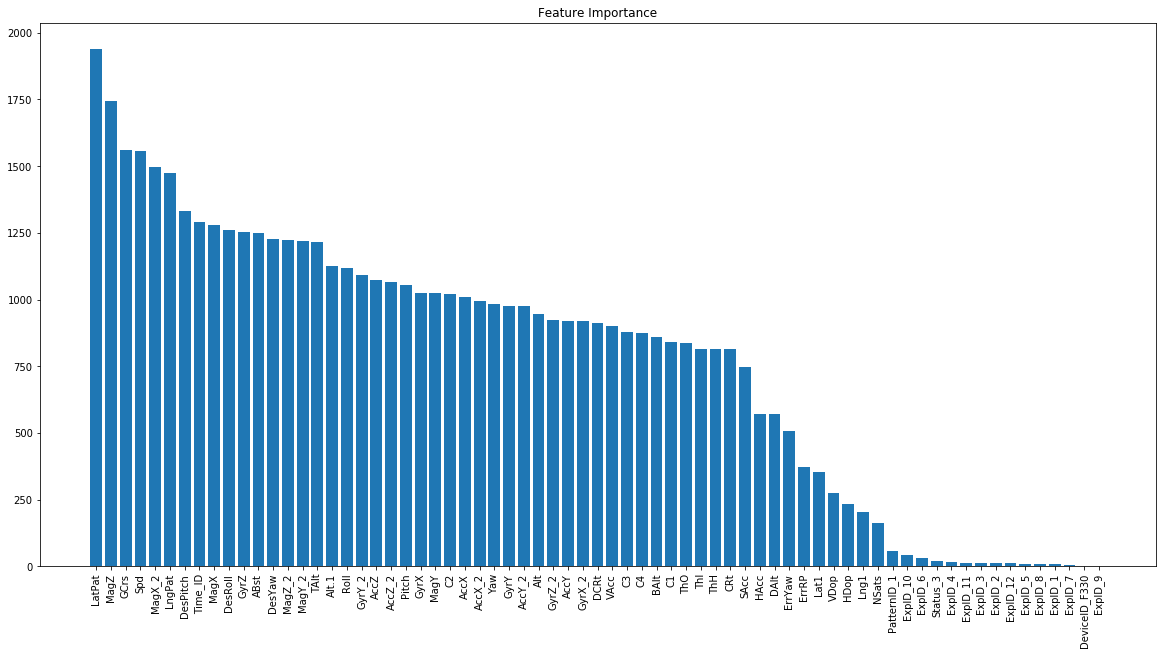

In [46]:
# Get sorted list of features in order of importance
feature_indices = np.argsort(model_lat.feature_importances_)
importances = model_lat.feature_importances_
indices = np.argsort(importances)[::-1]
names = [data_tr.columns[i] for i in indices]
# Create plot
plt.figure(figsize=(20,10))

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(data_tr.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(data_tr.shape[1]), names, rotation=90)

# Show plot
plt.show()

In [47]:
haversineTest = []
haversineTrain = []

for train_index, test_index in skf.split(data_tr):
    
    
    print("Train:", train_index, "Validation:",test_index)
    X_train, X_test = data_tr.iloc[train_index], data_tr.iloc[test_index] 
    y_trainlat, y_testlat = train_targetLat.iloc[train_index], train_targetLat.iloc[test_index]
    y_trainlng, y_testlng = train_targetLng.iloc[train_index], train_targetLng.iloc[test_index]
    
    model_lat = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=True)
    model_lat.fit(X_train, y_trainlat)
    train_predictions = model_lat.predict(X_train)
    val_predictions = model_lat.predict(X_test) 
    
    LatTrain = y_trainlat
    LatTrainPred = train_predictions
    LatTest = y_testlat
    LatTestPred = val_predictions
    
    model_lng =LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=True)
    model_lng.fit(X_train, y_trainlng)
    train_predictions = model_lng.predict(X_train)
    val_predictions = model_lng.predict(X_test) 
    

    LngTrain = y_trainlng
    LngTrainPred = train_predictions
    LngTest = y_testlng
    LngTestPred = val_predictions

    dfTrain = pd.DataFrame(data={'lon1':LngTrain,'lon2':LngTrainPred,'lat1':LatTrain,'lat2':LatTrainPred})
    dfTest = pd.DataFrame(data={'lon1':LngTest,'lon2':LngTestPred,'lat1':LatTest,'lat2':LatTestPred})
    kmTrain = haversine_np(dfTrain['lon1'],dfTrain['lat1'],dfTrain['lon2'],dfTrain['lat2'])
    kmTest = haversine_np(dfTest['lon1'],dfTest['lat1'],dfTest['lon2'],dfTest['lat2'])
    meanTrain = kmTrain.mean()
    meanTest = kmTest.mean()
    
    haversineTrain.append(meanTrain)
    haversineTest.append(meanTest)
    print('Haversine Train:'+format(meanTrain))
    print('Haversine Test:'+format(meanTest))
    print('')
    
print('')
print('Mean Haversine Train Cross Validation :')
train_scores = np.asarray(haversineTrain)
display_scores(train_scores)

    
print('')
print('Mean Haversine Test Cross Validation :')
test_scores = np.asarray(haversineTest)
display_scores(test_scores)

Train: [   0    1    2 ... 6437 6438 6439] Validation: [   4   21   28 ... 6426 6428 6429]
Haversine Train:0.005205715708256256
Haversine Test:0.005352705534324635

Train: [   0    2    4 ... 6431 6433 6437] Validation: [   1    3    5 ... 6436 6438 6439]
Haversine Train:0.005239023767618049
Haversine Test:0.005296037065236267

Train: [   0    1    2 ... 6437 6438 6439] Validation: [   6    7    9 ... 6416 6427 6430]
Haversine Train:0.005250510465300331
Haversine Test:0.005323048198403538

Train: [   1    2    3 ... 6436 6438 6439] Validation: [   0    8   22 ... 6402 6433 6437]
Haversine Train:0.005250563666742745
Haversine Test:0.005301600485755967

Train: [   0    1    3 ... 6437 6438 6439] Validation: [   2   14   15 ... 6420 6423 6431]
Haversine Train:0.005253589241627681
Haversine Test:0.005265483320273089


Mean Haversine Train Cross Validation :
Scores: [0.00520572 0.00523902 0.00525051 0.00525056 0.00525359]
Mean: 0.005239880569909013
Standard deviation: 1.7793385266425703e-05

In [48]:
model_lat

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [49]:
# # Get sorted list of features in order of importance
# feature_indices = np.argsort(model_lat.feature_importances_)
# importances = model_lat.feature_importances_
# indices = np.argsort(importances)[::-1]
# names = [data_tr.columns[i] for i in indices]
# # Create plot
# plt.figure(figsize=(20,10))

# # Create plot title
# plt.title("Feature Importance")

# # Add bars
# plt.bar(range(data_tr.shape[1]), importances[indices])

# # Add feature names as x-axis labels
# plt.xticks(range(data_tr.shape[1]), names, rotation=90)

# # Show plot
# plt.show()

In [50]:
haversineTest = []
haversineTrain = []

for train_index, test_index in skf.split(data_tr):
    
    
    print("Train:", train_index, "Validation:",test_index)
    X_train, X_test = data_tr.iloc[train_index], data_tr.iloc[test_index] 
    y_trainlat, y_testlat = train_targetLat.iloc[train_index], train_targetLat.iloc[test_index]
    y_trainlng, y_testlng = train_targetLng.iloc[train_index], train_targetLng.iloc[test_index]
    
    model_lat = lgb.LGBMRegressor(objective='regression',
                               learning_rate=0.05, n_estimators=300, num_leaves=200, 
                                  max_depth=30, colsample_bytree=0.5)
    
    model_lat.fit(X_train, y_trainlat)
    train_predictions = model_lat.predict(X_train)
    val_predictions = model_lat.predict(X_test) 
    
    model_lat2 = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=True)
    model_lat2.fit(X_train, y_trainlat)
    train_predictions2 = model_lat2.predict(X_train)
    val_predictions2 = model_lat2.predict(X_test) 
    
    LatTrain = y_trainlat
    LatTrainPred = train_predictions*0.5 + train_predictions2*0.5
    LatTest = y_testlat
    LatTestPred = val_predictions*0.5 + val_predictions2*0.5
    
    model_lng = lgb.LGBMRegressor(objective='regression',
                               learning_rate=0.05, n_estimators=300, num_leaves=200, 
                                  max_depth=30, colsample_bytree=0.5)
    model_lng.fit(X_train, y_trainlng)
    train_predictions = model_lng.predict(X_train)
    val_predictions = model_lng.predict(X_test) 
    
    model_lng2 = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,normalize=True)
    model_lng2.fit(X_train, y_trainlng)
    train_predictions2 = model_lng2.predict(X_train)
    val_predictions2 = model_lng2.predict(X_test) 

    LngTrain = y_trainlng
    LngTrainPred = train_predictions*0.5+ train_predictions2*0.5
    LngTest = y_testlng
    LngTestPred = val_predictions*0.5+ val_predictions2*0.5

    dfTrain = pd.DataFrame(data={'lon1':LngTrain,'lon2':LngTrainPred,'lat1':LatTrain,'lat2':LatTrainPred})
    dfTest = pd.DataFrame(data={'lon1':LngTest,'lon2':LngTestPred,'lat1':LatTest,'lat2':LatTestPred})
    kmTrain = haversine_np(dfTrain['lon1'],dfTrain['lat1'],dfTrain['lon2'],dfTrain['lat2'])
    kmTest = haversine_np(dfTest['lon1'],dfTest['lat1'],dfTest['lon2'],dfTest['lat2'])
    meanTrain = kmTrain.mean()
    meanTest = kmTest.mean()
    
    haversineTrain.append(meanTrain)
    haversineTest.append(meanTest)
    print('Haversine Train:'+format(meanTrain))
    print('Haversine Test:'+format(meanTest))
    print('')
    
print('')
print('Mean Haversine Train Cross Validation :')
train_scores = np.asarray(haversineTrain)
display_scores(train_scores)
 
print('')
print('Mean Haversine Test Cross Validation :')
test_scores = np.asarray(haversineTest)
display_scores(test_scores)

Train: [   0    1    2 ... 6437 6438 6439] Validation: [   4   21   28 ... 6426 6428 6429]
Haversine Train:0.002612636894150905
Haversine Test:0.002851549895109282

Train: [   0    2    4 ... 6431 6433 6437] Validation: [   1    3    5 ... 6436 6438 6439]
Haversine Train:0.002627841895805598
Haversine Test:0.002836540277732679

Train: [   0    1    2 ... 6437 6438 6439] Validation: [   6    7    9 ... 6416 6427 6430]
Haversine Train:0.0026352977894300903
Haversine Test:0.0028220789753996196

Train: [   1    2    3 ... 6436 6438 6439] Validation: [   0    8   22 ... 6402 6433 6437]
Haversine Train:0.002633125411023313
Haversine Test:0.0028031551923666524

Train: [   0    1    3 ... 6437 6438 6439] Validation: [   2   14   15 ... 6420 6423 6431]
Haversine Train:0.0026357617999275495
Haversine Test:0.002800851820473623


Mean Haversine Train Cross Validation :
Scores: [0.00261264 0.00262784 0.0026353  0.00263313 0.00263576]
Mean: 0.002628932758067491
Standard deviation: 8.619430805378965e

In [51]:
haversineTest = []
haversineTrain = []

for train_index, test_index in skf.split(data_tr):
    
    
    print("Train:", train_index, "Validation:",test_index)
    X_train, X_test = data_tr.iloc[train_index], data_tr.iloc[test_index] 
    y_trainlat, y_testlat = train_targetLat.iloc[train_index], train_targetLat.iloc[test_index]
    y_trainlng, y_testlng = train_targetLng.iloc[train_index], train_targetLng.iloc[test_index]
    
    model_lat = lgb.LGBMRegressor(objective='regression',
                               learning_rate=0.05, n_estimators=300, num_leaves=200, max_depth=30, colsample_bytree=0.5)
    
    model_lat.fit(X_train, y_trainlat)
    train_predictions = model_lat.predict(X_train)
    val_predictions = model_lat.predict(X_test) 
    
    model_lat2 = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=True)
    model_lat2.fit(X_train, y_trainlat)
    train_predictions2 = model_lat2.predict(X_train)
    val_predictions2 = model_lat2.predict(X_test) 
    
    LatTrain = y_trainlat
    LatTrainPred = train_predictions*0.5 + train_predictions2*0.5
    LatTest = y_testlat
    LatTestPred = val_predictions*0.5 + val_predictions2*0.5
    
    model_lng = lgb.LGBMRegressor(objective='regression',
                               learning_rate=0.05, n_estimators=300, num_leaves=200, max_depth=30, colsample_bytree=0.5)
    model_lng.fit(X_train, y_trainlng)
    train_predictions = model_lng.predict(X_train)
    val_predictions = model_lng.predict(X_test) 
    
    model_lng2 = LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=True)
    model_lng2.fit(X_train, y_trainlng)
    train_predictions2 = model_lng2.predict(X_train)
    val_predictions2 = model_lng2.predict(X_test) 

    LngTrain = y_trainlng
    LngTrainPred = train_predictions*0.5+ train_predictions2*0.5
    LngTest = y_testlng
    LngTestPred = val_predictions*0.5+ val_predictions2*0.5

    dfTrain = pd.DataFrame(data={'lon1':LngTrain,'lon2':LngTrainPred,'lat1':LatTrain,'lat2':LatTrainPred})
    dfTest = pd.DataFrame(data={'lon1':LngTest,'lon2':LngTestPred,'lat1':LatTest,'lat2':LatTestPred})
    kmTrain = haversine_np(dfTrain['lon1'],dfTrain['lat1'],dfTrain['lon2'],dfTrain['lat2'])
    kmTest = haversine_np(dfTest['lon1'],dfTest['lat1'],dfTest['lon2'],dfTest['lat2'])
    meanTrain = kmTrain.mean()
    meanTest = kmTest.mean()
    
    haversineTrain.append(meanTrain)
    haversineTest.append(meanTest)
    print('Haversine Train:'+format(meanTrain))
    print('Haversine Test:'+format(meanTest))
    print('')
    
print('')
print('Mean Haversine Train Cross Validation :')
train_scores = np.asarray(haversineTrain)
display_scores(train_scores)

    
print('')
print('Mean Haversine Test Cross Validation :')
test_scores = np.asarray(haversineTest)
display_scores(test_scores)

Train: [   0    1    2 ... 6437 6438 6439] Validation: [   4   21   28 ... 6426 6428 6429]
Haversine Train:0.002612636894150905
Haversine Test:0.002851549895109282

Train: [   0    2    4 ... 6431 6433 6437] Validation: [   1    3    5 ... 6436 6438 6439]
Haversine Train:0.002627841895805598
Haversine Test:0.002836540277732679

Train: [   0    1    2 ... 6437 6438 6439] Validation: [   6    7    9 ... 6416 6427 6430]
Haversine Train:0.0026352977894300903
Haversine Test:0.0028220789753996196

Train: [   1    2    3 ... 6436 6438 6439] Validation: [   0    8   22 ... 6402 6433 6437]
Haversine Train:0.002633125411023313
Haversine Test:0.0028031551923666524

Train: [   0    1    3 ... 6437 6438 6439] Validation: [   2   14   15 ... 6420 6423 6431]
Haversine Train:0.0026357617999275495
Haversine Test:0.002800851820473623


Mean Haversine Train Cross Validation :
Scores: [0.00261264 0.00262784 0.0026353  0.00263313 0.00263576]
Mean: 0.002628932758067491
Standard deviation: 8.619430805378965e

In [52]:
model_lat.fit(data_tr, train_targetLat)
model_lng.fit(data_tr, train_targetLng)
data_lat = model_lat.predict(data_tr)
data_lng = model_lng.predict(data_tr)

model_lng2.fit(data_tr, train_targetLat)
model_lat2.fit(data_tr, train_targetLng)

data_lat2 = model_lat2.predict(data_tr)
data_lng2 = model_lng2.predict(data_tr)

In [53]:
datastack = pd.DataFrame(data={'lon1':data_lng,
                               'lon2':data_lng2,
                               'lat1':data_lat,
                               'lat2':data_lat2,
                               'lonAct' : train_targetLng,
                               'latAct' : train_targetLat
                              })

In [54]:
datastack.head()

,lon1,lon2,lat1,lat2,lonAct,latAct
0,106.733963,-6.557160,-6.557158,106.733935,106.733964,-6.557158
1,106.733963,-6.557196,-6.557158,106.733961,106.733964,-6.557158
2,106.733963,-6.557195,-6.557158,106.733964,106.733964,-6.557159
3,106.733963,-6.557195,-6.557159,106.733960,106.733964,-6.557159
4,106.733963,-6.557201,-6.557158,106.733958,106.733964,-6.557159


In [55]:
test_lat = model_lat.predict(data_ts)
test_lng = model_lng.predict(data_ts)
test_lat2 = model_lat2.predict(data_ts)
test_lng2 = model_lng2.predict(data_ts)

In [56]:
teststack = pd.DataFrame(data={'lon1':test_lng,
                               'lon2':test_lng2,
                               'lat1':test_lat,
                               'lat2':test_lat2
                              })

In [57]:
data_tr = datastack.drop(['lonAct','latAct'],axis =1)
train_targetLat = datastack.latAct
train_targetLng = datastack.lonAct

In [58]:
haversineTest = []
haversineTrain = []

for train_index, test_index in skf.split(data_tr):
    
    
    print("Train:", train_index, "Validation:",test_index)
    X_train, X_test = data_tr.iloc[train_index], data_tr.iloc[test_index] 
    y_trainlat, y_testlat = train_targetLat.iloc[train_index], train_targetLat.iloc[test_index]
    y_trainlng, y_testlng = train_targetLng.iloc[train_index], train_targetLng.iloc[test_index]
    
    model_lat = lgb.LGBMRegressor()
    model_lat.fit(X_train, y_trainlat)
    train_predictions = model_lat.predict(X_train)
    val_predictions = model_lat.predict(X_test) 
    
    LatTrain = y_trainlat
    LatTrainPred = train_predictions
    LatTest = y_testlat
    LatTestPred = val_predictions
    
    model_lng = lgb.LGBMRegressor()
    model_lng.fit(X_train, y_trainlng)
    train_predictions = model_lng.predict(X_train)
    val_predictions = model_lng.predict(X_test) 

    LngTrain = y_trainlng
    LngTrainPred = train_predictions
    LngTest = y_testlng
    LngTestPred = val_predictions

    dfTrain = pd.DataFrame(data={'lon1':LngTrain,'lon2':LngTrainPred,'lat1':LatTrain,'lat2':LatTrainPred})
    dfTest = pd.DataFrame(data={'lon1':LngTest,'lon2':LngTestPred,'lat1':LatTest,'lat2':LatTestPred})
    kmTrain = haversine_np(dfTrain['lon1'],dfTrain['lat1'],dfTrain['lon2'],dfTrain['lat2'])
    kmTest = haversine_np(dfTest['lon1'],dfTest['lat1'],dfTest['lon2'],dfTest['lat2'])
    meanTrain = kmTrain.mean()
    meanTest = kmTest.mean()
    
    haversineTrain.append(meanTrain)
    haversineTest.append(meanTest)
    print('Haversine Train:'+format(meanTrain))
    print('Haversine Test:'+format(meanTest))
    print('')
    
print('')
print('Mean Haversine Train Cross Validation :')
train_scores = np.asarray(haversineTrain)
display_scores(train_scores)

    
print('')
print('Mean Haversine Test Cross Validation :')
test_scores = np.asarray(haversineTest)
display_scores(test_scores)

Train: [   0    1    2 ... 6437 6438 6439] Validation: [   4   21   28 ... 6426 6428 6429]
Haversine Train:0.00024865419503463065
Haversine Test:0.0002875354690014903

Train: [   0    2    4 ... 6431 6433 6437] Validation: [   1    3    5 ... 6436 6438 6439]
Haversine Train:0.00024903695239748315
Haversine Test:0.00027289708636645985

Train: [   0    1    2 ... 6437 6438 6439] Validation: [   6    7    9 ... 6416 6427 6430]
Haversine Train:0.00024995793277529703
Haversine Test:0.00026438339559759855

Train: [   1    2    3 ... 6436 6438 6439] Validation: [   0    8   22 ... 6402 6433 6437]
Haversine Train:0.00025002695240224955
Haversine Test:0.0002675960209268361

Train: [   0    1    3 ... 6437 6438 6439] Validation: [   2   14   15 ... 6420 6423 6431]
Haversine Train:0.00024770280052151754
Haversine Test:0.0002775777698363398


Mean Haversine Train Cross Validation :
Scores: [0.00024865 0.00024904 0.00024996 0.00025003 0.0002477 ]
Mean: 0.00024907576662623555
Standard deviation: 8.6

In [59]:
model_lat.fit(data_tr, train_targetLat)
model_lng.fit(data_tr, train_targetLng)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [60]:
Lat = model_lat.predict(teststack)
Lng = model_lng.predict(teststack)

Lat30 = model_lat.predict(data_tr)
Lng30 = model_lng.predict(data_tr)
df30 = pd.DataFrame({ 'id': data_tr.index,'Lng30': Lng30, 'Lat30': Lat30, 'targetLat': train_targetLat, 'targetLng' : train_targetLng})
df30.to_csv('df30.csv')


df = pd.DataFrame({ 'id': teststack.index,'Lng': Lng, 'Lat': Lat})
df.index = df.id

submission = pd.read_csv("sampleSubmission.csv")
submission.iloc[:,1] = Lng
submission.iloc[:,2] = Lat
submission.index = submission.id
submission = submission.drop(['id'],axis = 1)
submission.to_csv('sub30-stackLGB-LR.csv')
submission

,Lng,Lat
id,,
516,106.734208,-6.557208
517,106.734208,-6.557210
518,106.734194,-6.557201
519,106.734193,-6.557167
520,106.734202,-6.557162
521,106.734200,-6.557162
522,106.734202,-6.557140
523,106.734203,-6.557137
524,106.734186,-6.557146


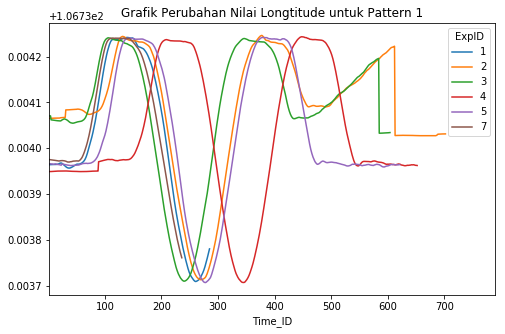

In [61]:
# a bit Exploration
df = data[data['PatternID'] == 1]
df = df.pivot(index='Time_ID', columns='ExpID', values='Lng')
df.plot(figsize= (8,5), title= 'Grafik Perubahan Nilai Longtitude untuk Pattern 1')

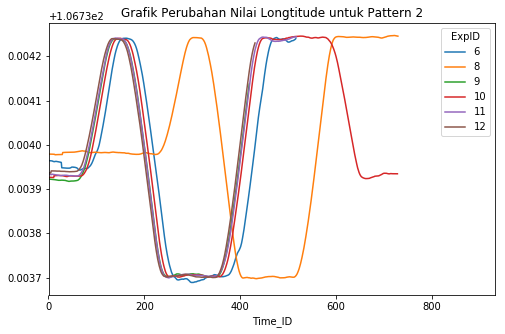

In [62]:
# a bit Exploration
df = data[data['PatternID'] == 2]
df = df.pivot(index='Time_ID', columns='ExpID', values='Lng')
df.plot(figsize= (8,5), title= 'Grafik Perubahan Nilai Longtitude untuk Pattern 2')

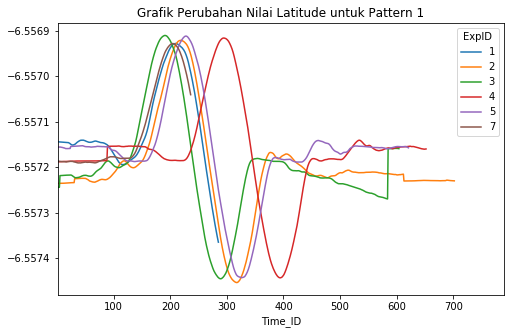

In [63]:
# a bit Exploration
df = data[data['PatternID'] == 1]
df = df.pivot(index='Time_ID', columns='ExpID', values='Lat')
df.plot(figsize= (8,5), title= 'Grafik Perubahan Nilai Latitude untuk Pattern 1')

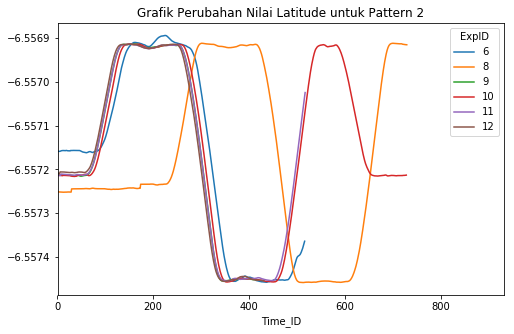

In [64]:
# a bit Exploration
df = data[data['PatternID'] == 2]
df = df.pivot(index='Time_ID', columns='ExpID', values='Lat')
df.plot(figsize= (8,5), title= 'Grafik Perubahan Nilai Latitude untuk Pattern 2')